This notebook includes an algorithm for creating networks of parliamenty speeches based on prefered topics of every MP. First we create a bipartite network connecting MP to topics they had discussions preferences. By preference, it means that the topic has a proportion bigger than 10% from the topic modelling analysis in each year. Secondly we create a projection onto the MPs connecting those who share a prefered topic.

In [1]:
%matplotlib inline
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
import math
import random
import pandas as pd
import csv
import itertools
from itertools import izip_longest
from itertools import izip
import collections
from collections import defaultdict
import time
import operator
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import community
from collections import Counter
from collections import OrderedDict
import os
import subprocess
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import copy

The dataframe is imported from the outcome file from mallet with proportions of topics by mp, by year. The file is manipulated to show topics ordered by number by proportion.

In [2]:
df = pd.read_csv('donenetwork47-50.csv')

In [3]:
#MPfiles = df['files'].values.tolist() #speeches of each MP by year
names = df['name'].values.tolist() #name of MP
surnames = df['surname'].values.tolist()
terms = df['term'].values.tolist()
#years = df['year'].values.tolist()
words = df['wordcount'].values.tolist()

In [4]:
mps = []
full_name = []
for i in range(len(names)):
    mps.append(surnames[i]+'-'+names[i])
    full_name.append(names[i].title()+' '+surnames[i].title())
    terms[i] = str(terms[i]) 

In [5]:
#some testing
print len(mps), len(words)
print type(mps[0]), type(words[0]) 

print mps[0]
print type(mps[0]), type(terms[0])

515 515
<type 'str'> <type 'int'>
adams-paul
<type 'str'> <type 'str'>


#### Functions not being used

In [ ]:
#function to find positioning of forward bar (to get only the mp name)
def dash_positions(url):
    
    s = url
    c = '/'
    #positions = [pos for pos, char in enumerate(s) if char == c]
    #print speech_urls[205][0].index('-')
    for pos, char in enumerate(s):
        if char == c:
            positions = pos
    
    return positions

In [ ]:
#function to get MP name from each file
def get_mp(MPfiles):
    
    mps = []
    
    for i in range(len(MPfiles)):
        
        positions = dash_positions(MPfiles[i])

        mp_name = MPfiles[i][0:positions] #string
        mps.append(mp_name)
        
    return mps

In [ ]:
#function to get the year (when importing files by years instaed of by terms)
def get_years(MPfiles):
    
    years = []
    
    for i in range (len(MPfiles)):
        
        positions = dash_positions(MPfiles[i])
        
        year = MPfiles[i][positions[7]+4:positions[7]+8] #string
        years.append(year)
        
    return years

In [ ]:
#function to get the term
def get_terms(MPfiles):
    
    terms = []
    
    for i in range (len(MPfiles)):
        
        positions = dash_positions(MPfiles[i])
        
        term = MPfiles[i][positions+1:positions+3] #string
        terms.append(term)
        
    return terms

Calling the functions will give lists in which the index will be the key to relate mp name, year and term. Same happens when we create lists for each topics. In the end we have each index of the lists linking: mp name, year, term and proportion of each topic. CURRENTLY NOT BEING USED!

In [ ]:
mps = get_mp(MPfiles)
print len(mps)

#years = get_years(MPfiles)
#print len(years)

terms = get_terms(MPfiles)
print len(terms)

for i in range(10):
    print mps[i], terms[i]
    
print type(terms[0])

#### Restart here

In [6]:
#based on file 'byyear-standardstop-150plus-20161101-keys.csv'
topics = []
topic_class = []

for i in range(30):
    topics.append(df[str(i)].values.tolist())
    
with open('byyear-standardstop-150plus-20161101-keys.csv', 'rb') as csvfile:
    read = csv.reader(csvfile)
    for row in read:
        topic_class.append(row[0])
        
print topic_class

['Foreign affairs', 'Procedural terms', 'Law and order', 'Tax', 'Budget', 'Government', 'Legislation', 'Political party', 'Economy', 'Social welfare', 'Education', 'Primary industries', 'Environment', 'Maori/Treaty of Waitangi', 'Rhetoric', 'Rhetoric', 'Crime', 'Drugs', 'Local government', 'Housing', 'Canterbury', 'Growth', 'Miscellaneous', 'Procedural terms', 'Procedural terms', 'Healthcare', 'Transport', 'Finance', 'Procedural terms', 'Employment']


The following dataframe (df2) relates MPs to their parties and to the number of times they are sitting on the parliament

In [7]:
df2 = pd.read_csv('countTerms47-50.csv')

In [8]:
mp_unique = df2['Name'].values.tolist()
party = df2['Party'].values.tolist()
presence = df2['Presence'].values.tolist()

In [9]:
mp_id = []
ids = 0
for mp in mp_unique:
    ids += 1
    mp_id.append(ids)

In [10]:
print len(mp_unique) #number of different MPs throughout the whole dataset
print len(mp_id)
print mp_unique[230]

231
231
kelly-graham


Here new lists are created in the same fashion as before, where the indexes function as keys to the database

In [11]:
mp_party = []
mp_presence = []
mp_ids = []

for mp in mps:
    for i in range(len(mp_unique)):
        if mp == mp_unique[i]:
            mp_party.append(party[i])
            mp_presence.append(presence[i])
            mp_ids.append(str(mp_id[i]))
            #print mp, mp_unique[i], party[i]         

In [12]:
#To guarantee that there is no duplicate MP
for mp in mps:
    if mp not in mp_unique:
        print mp

In [13]:
#Testing
for i in range(10):
    print mps[i], mp_party[i], mp_ids[i]
print type(mp_party[0]), type(mp_ids[0])

adams-paul United Future 117
alexander-marc United Future 127
anderton-jim Progressive 92
ardern-shane National 206
awatere-huata ACT 149
baldock-larry United Future 2
barker-rick Labour 201
barnett-tim Labour 90
bennett-paula National 213
benson-pope Labour 45
<type 'str'> <type 'str'>


Here we set the threshold that defines preference. We are arbritarily choosing 6.5%. That means that with the topic has more than 6.5% as proportion of all speeches within the same year, this topic is assigned as a prefered topic of that MP. We also remove rhetoric, parliament terms, ramble words topics.

In [14]:
topic_list = [] #topic list for mps
x_topics = ['Procedural terms','Rhetoric','Miscellaneous','Political party', \
            'Maori/Treaty of Waitangi']

for i in range(len(mps)): 
    list_mp = []
    #t = 0
    for j in range(len(topics)):
    #for topic in topics: #topics is the list with the proportions of each topic
        if topics[j][i] > 0.065 and topic_class[j] in (set(topic_class)-set(x_topics)):
            list_mp.append(topic_class[j])
        #t += 1
    topic_list.append(list_mp)

In [15]:
for i in range(10):
    print topic_list[i]

['Transport', 'Employment']
['Crime']
['Economy']
['Primary industries', 'Environment']
['Education']
['Legislation', 'Environment', 'Drugs', 'Transport']
['Law and order', 'Legislation']
['Law and order', 'Crime', 'Drugs']
['Social welfare']
['Legislation']


The following function creates the bipartite network linking MPs to topics, based on the lists indexes. Bottom nodes are MPs in mps list, top nodes are topics in topic list. Party and presence (number of terms) are attributes. Year and term are keys for constructing different networks. If nod term or year is given, the network over the whole dat is built. If year or term is given, the network is built based on the given argument. 

In [16]:
def create_network(mps, mp_ids, full_name, topic_list, mp_party, terms, words, mp_presence, term=None, year=None):

    t0 = time.time()
    
    #CREATE NETWORK
    B = nx.Graph()
    
    if year == None and term == None:
        for i in range(len(mps)):
            B.add_node(mps[i], bipartite=1, party=mp_party[i], presence=mp_presence[i])
            for topic in topic_list[i]:
                B.add_node(topic, bipartite=0)
                B.add_edge(mps[i],topic)
                
    else:
        if year == None:
            for i in range(len(mps)):
                if terms[i] == term:
                    if words[i] > 10000:
                        B.add_node(mps[i], bipartite=1, name=full_name[i], words=words[i], party=mp_party[i], \
                                   presence=mp_presence[i], code=mp_ids[i])
                        for topic in topic_list[i]:
                            B.add_node(topic, bipartite=0)
                            B.add_edge(mps[i],topic)
                        
        else:
            for i in range(len(mps)):
                if years[i] == year:
                    B.add_node(mps[i], bipartite=1, party=mp_party[i], presence=mp_presence[i], words=words[i])
                    for topic in topic_list[i]:
                        B.add_node(topic, bipartite=0)
                        B.add_edge(mps[i],topic)           

    print 'Running time to create network: ' + str(time.time() - t0)
    
    return B

The next three functions create bottom projections, or the network of MPs linking MPs who shared prefered topics within that time frame. The first creates a simple projection while the second creates a weighted projection and the third a multigraph projection.

In [17]:
def create_bottom_projection(B):

    t0 = time.time()
    
    #BIPARTITE NETWORK
    top_nodes = set(node for node,d in B.nodes(data=True) if d['bipartite']==0) #dlist
    bottom_nodes = set(B) - top_nodes #klist
    #deg_top, deg_bottom = bipartite.degrees(B,bottom_nodes) #dictionary
    
    G_bottom = bipartite.projected_graph(B,bottom_nodes)

    print 'Running time to create projection: ' + str(time.time() - t0)
    
    return G_bottom

In [18]:
def create_bottom_weighted_projection(B):

    t0 = time.time()
    
    #BIPARTITE NETWORK
    top_nodes = set(node for node,d in B.nodes(data=True) if d['bipartite']==0) #dlist
    bottom_nodes = set(B) - top_nodes #klist
    #deg_top, deg_bottom = bipartite.degrees(B,bottom_nodes) #dictionary
    
    G_bottom = bipartite.weighted_projected_graph(B,bottom_nodes)

    print 'Running time to create projection: ' + str(time.time() - t0)
    
    return G_bottom

In [19]:
def create_bottom_multigraph_projection(B):

    t0 = time.time()
    
    #BIPARTITE NETWORK
    top_nodes = set(node for node,d in B.nodes(data=True) if d['bipartite']==0) #dlist
    bottom_nodes = set(B) - top_nodes #klist
    #deg_top, deg_bottom = bipartite.degrees(B,bottom_nodes) #dictionary
    
    G_bottom = bipartite.projected_graph(B,bottom_nodes,multigraph=True)

    print 'Running time to create projection: ' + str(time.time() - t0)
    
    return G_bottom

In [20]:
def conf_model(G_list):
    
    Gm_CM = []
    for G in G_list:
        G_CM = copy.deepcopy(G)
        Gm_CM.append(G_CM)
        
    q_dict = []
    q_seq = []
    for i in range(len(Gm_CM)):
        q_dict.append(Gm_CM[i].degree())
        Gm_CM[i].remove_edges_from(Gm_CM[i].edges())
        q = []
        for node,degree in q_dict[i].iteritems():
            q.extend([node]*degree)
        q_seq.append(q)
        
    #print q_dict
    #print q_seq
        
    for i in range(len(Gm_CM)):
        stublist = copy.deepcopy(q_seq[i])
        random.shuffle(stublist)
        while stublist:
            n1 = stublist.pop()
            n2 = stublist.pop()
            Gm_CM[i].add_edge(n1,n2)
    
    return Gm_CM

## $47th$, $48th$, $49th$ and $50th$ Parliament

In [21]:
#Parliaments of interest 47, 48, 49, 50
parl_string = ['47','48','49','50']
parl_text_test = [r'$47th$',r'$48th$',r'$49th$',r'$50th$']
parl_text = ['$\mathregular{47^{th}}$','$\mathregular{48^{th}}$','$\mathregular{49^{th}}$','$\mathregular{50^{th}}$']
B = []
Gw = []
Gm = []

for i in range(len(parl_string)):
    B.append(create_network(mps, mp_ids, full_name, topic_list,\
                                 mp_party, terms, words, mp_presence, term=parl_string[i], year=None))

for i in range(len(B)):
    Gw.append(create_bottom_weighted_projection(B[i]))
    Gm.append(create_bottom_multigraph_projection(B[i]))

Running time to create network: 0.00101208686829
Running time to create network: 0.00119304656982
Running time to create network: 0.00138187408447
Running time to create network: 0.00146007537842
Running time to create projection: 0.00722217559814
Running time to create projection: 0.0112328529358
Running time to create projection: 0.00654721260071
Running time to create projection: 0.0114169120789
Running time to create projection: 0.0127670764923
Running time to create projection: 0.0181329250336
Running time to create projection: 0.0119490623474
Running time to create projection: 0.0218861103058


In [ ]:
nx.write_gexf(Gw[0], "47th_mps_weighted.gexf")
nx.write_gexf(Gw[1], "48th_mps_weighted.gexf")
nx.write_gexf(Gw[2], "49th_mps_weighted.gexf")
nx.write_gexf(Gw[3], "50th_mps_weighted.gexf")

In the next section we have functions for network analysis:
- Bipartite degree distribution
- Projection degree distribution
- Average degree (average overall and divided bu parties: National, Labour, Greens)
- Betweeness centrality (ranking top 10 MPs)
- Shortest path (average overall and divided bu parties: National, Labour, Greens)
- Clustering (average overall and divided bu parties: National, Labour, Greens)
- Homophily (average overall and divided bu parties: National, Labour, Greens)

In [22]:
def bipartite_distribution(degree_dict):
    
    t0 = time.time()
    
    #Degree Distribution
    degree_list = degree_dict.values()
    P = []
    for d in range(0,max(degree_list)+1,1):
        if d in degree_list:
            f = degree_list.count(d)
            P.append(f)
        else:
            P.append(0)
            
    PDF = []
    CCDF = []
    for i, d in enumerate(P):
        PDF.append(float(d)/sum(P))
        CCDF.append(sum(P[i:])/float(sum(P)))
        
    print 'Running time to create distribution: ' + str(time.time() - t0)
        
    return CCDF, PDF

In [23]:
def projection_distribution(G):
    
    t0 = time.time()
    
    #Projection distribution
    degree_hist = nx.degree_histogram(G)
    q_list = []
    Pq = []
    for degree, num_of_nodes in enumerate(degree_hist):
        q_list.append(degree)
        Pq.append(num_of_nodes)
        
    PDF = []
    CCDF = []
    for i,q in enumerate(Pq):
        PDF.append(float(q)/sum(Pq))
        CCDF.append(sum(Pq[i:])/float(sum(Pq)))
        
    print 'Running time to create distribution: ' + str(time.time() - t0)  
    
    return CCDF, PDF

In [24]:
#Create separate sets of nodes divided by party
National = []
Labour = []
Greens = []
Maori = []
Progressive = []
United = []
Mana = []
ACT = []
First = []

for i in range(len(mps)):
    if mp_party[i] == 'National':
        National.append(mps[i])
    if mp_party[i] == 'Labour':
        Labour.append(mps[i])
    if mp_party[i] == 'Greens':
        Greens.append(mps[i])
    if mp_party[i] == 'Maori':
        Maori.append(mps[i])
    if mp_party[i] == 'Progressive':
        Progressive.append(mps[i])
    if mp_party[i] == 'United Future':
        United.append(mps[i])
    if mp_party[i] == 'Mana':
        Mana.append(mps[i])
    if mp_party[i] == 'ACT':
        ACT.append(mps[i])
    if mp_party[i] == 'First':
        First.append(mps[i])
        
#using set because set returns non repeated nodes
National = list(set(National))
Labour = list(set(Labour))
Greens = list(set(Greens))
Maori = list(set(Maori))
Progressive = list(set(Progressive))
United = list(set(United))
Mana = list(set(Mana))
ACT = list(set(ACT))
First = list(set(First))

party_nodelist = [National,Labour,Greens,Maori,Progressive,United,Mana,ACT,First]
party_nodelist_others = [Maori,Progressive,United,Mana,ACT,First]

In [25]:
others = [item for sublist in party_nodelist_others for item in sublist]

In [26]:
party_node_list_four = [National,Labour,Greens,others]

In [27]:
print National, len(National)
print ' '
print Labour, len(Labour)
print ' '
print Greens, len(Greens)
print ' '
print others, len(others)

['finlayson-christopher', 'wagner-nicky', 'roy-eric', 'tolley-anne', 'bennett-david', 'goodhew-jo', 'rich-katherine', 'quinn-paul', 'goldsmith-paul', 'bridges-simon', 'mckelvie-ian', 'macindoe-tim', 'key-john', 'sharples-pita', 'carter-david', 'barry-maggie', 'ross-jami', 'bennett-paula', 'tremain-chris', 'sabin-mike', 'franks-stephen', 'hayes-john', 'young-jonathan', 'clarkson-bob', 'woodhouse-michael', 'scott-lynda', 'peachey-allan', 'auchinvole-chris', 'brownlee-gerry', 'blumsky-mark', 'lotu-iiga', 'connell-brian', 'hauiti-claudette', 'sowry-roger', 'wilkinson-kate', 'te-heuheu', 'mccully-murray', 'mapp-wayne', 'lee-melissa', 'mitchell-mark', 'gilmore-aaron', 'borrows-chester', 'groser-tim', 'kaye-nikki', 'hutchison-paul', 'banks-john', 'brash-don', 'guy-nathan', 'smith-nick', 'smith-lockwood', 'adams-amy', 'power-simon', 'upston-louise', 'king-colin', 'simich-clem', 'henare-tau', 'paul-foster', 'hayes-joanne', 'foster-bell', 'ardern-shane', 'shanks-katrina', 'ngaro-alfred', 'simpso

In [28]:
for i in range(len(B)):
    print B[i]['key-john']

{'Budget': {}}
{'Budget': {}}
{'Budget': {}, 'Economy': {}}
{'Budget': {}, 'Economy': {}}


In [29]:
for i in range(len(B)):
    print B[i]['Growth']

{'brash-don': {}, 'cullen-michael': {}, 'clark-helen': {}, 'hereora-dave': {}}
{'parker-david': {}, 'clark-helen': {}, 'benson-pope': {}}
{'groser-tim': {}, 'douglas-roger': {}}
{'yang-jian': {}}


## Degree distribution

In [30]:
deg_bottom_list = []
deg_top_list = []

for i in range(len(B)):
    top_nodes = set(node for node,d in B[i].nodes(data=True) if d['bipartite']==0) #dlist
    bottom_nodes = set(B[i]) - top_nodes #klist
    deg_top, deg_bottom = bipartite.degrees(B[i],bottom_nodes) #dictionary
    deg_bottom_list.append(deg_bottom)
    deg_top_list.append(deg_top)

In [31]:
sorted_deg_top_list = []
for i in range(len(deg_top_list)):
    sorted_deg_top_list.append(sorted(deg_top_list[i].items(), key=operator.itemgetter(1)))
print sorted_deg_top_list

[[('Housing', 1), ('Local government', 3), ('Government', 4), ('Growth', 4), ('Employment', 6), ('Primary industries', 7), ('Economy', 7), ('Drugs', 8), ('Crime', 9), ('Education', 9), ('Social welfare', 11), ('Budget', 11), ('Healthcare', 11), ('Environment', 12), ('Transport', 12), ('Law and order', 15), ('Legislation', 17), ('Foreign affairs', 17)], [('Drugs', 2), ('Tax', 2), ('Government', 3), ('Growth', 3), ('Economy', 3), ('Local government', 5), ('Finance', 6), ('Housing', 6), ('Crime', 7), ('Environment', 7), ('Transport', 7), ('Budget', 9), ('Foreign affairs', 9), ('Education', 10), ('Employment', 10), ('Social welfare', 11), ('Primary industries', 11), ('Healthcare', 11), ('Law and order', 13), ('Legislation', 19)], [('Government', 2), ('Growth', 2), ('Housing', 3), ('Tax', 4), ('Foreign affairs', 4), ('Transport', 5), ('Healthcare', 7), ('Drugs', 8), ('Employment', 8), ('Primary industries', 9), ('Environment', 10), ('Finance', 11), ('Social welfare', 12), ('Law and order', 

In [32]:
Pd_CCDF = []
Pd_PDF = []
Pk_CCDF = []
Pk_PDF = []
Pq_CCDF = []
Pq_PDF = []
for i in range(len(Gw)):
    
    #calling PDF and CCDF from bipartite set
    Pd_CCDFx, Pd_PDFx = bipartite_distribution(deg_top_list[i])
    Pk_CCDFx, Pk_PDFx = bipartite_distribution(deg_bottom_list[i])
    #calling PDF and CCDF from projections (simple)
    Pq_CCDFx, Pq_PDFx = projection_distribution(Gw[i])
    
    Pd_CCDF.append(Pd_CCDFx)
    Pd_PDF.append(Pd_PDFx)
    Pk_CCDF.append(Pk_CCDFx)
    Pk_PDF.append(Pk_PDFx)
    Pq_CCDF.append(Pq_CCDFx)
    Pq_PDF.append(Pq_PDFx)    

Running time to create distribution: 6.48498535156e-05
Running time to create distribution: 3.60012054443e-05
Running time to create distribution: 0.000282049179077
Running time to create distribution: 6.103515625e-05
Running time to create distribution: 2.69412994385e-05
Running time to create distribution: 0.000280857086182
Running time to create distribution: 9.01222229004e-05
Running time to create distribution: 3.50475311279e-05
Running time to create distribution: 0.000385046005249
Running time to create distribution: 0.000159025192261
Running time to create distribution: 4.38690185547e-05
Running time to create distribution: 0.000669002532959


### Projected network

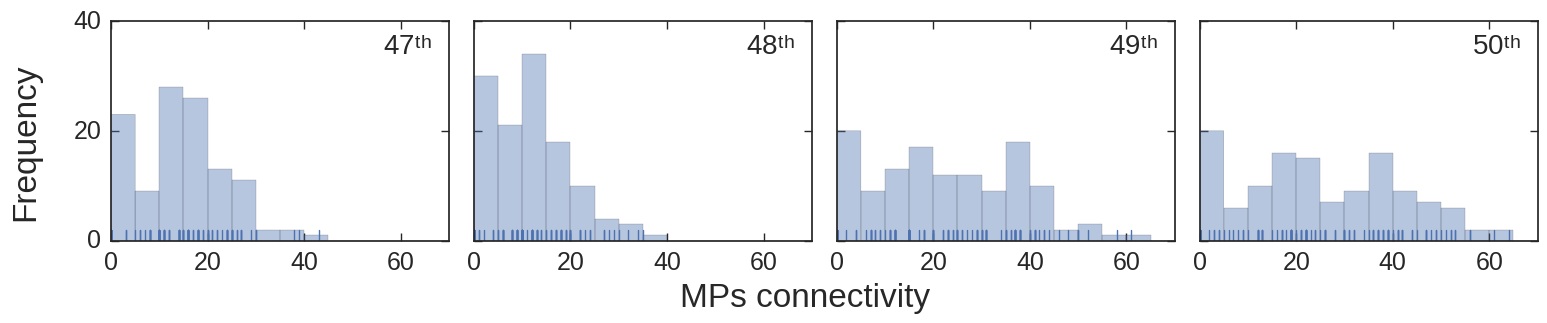

In [33]:
#Projected network
import seaborn as sns
sns.set(color_codes=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"})

fig = plt.figure(figsize=(15,3), dpi=500)
ax = [fig.add_subplot(1,4,i+1) for i in range(4)]

for i in range(4):
    #plt.subplot(4,1,i+1)
    data = Gw[i].degree().values()
    bins = np.arange(0,90,5)
    #bins = range(min(deg_bottom1.values()), max(deg_bottom1.values()), 5)
    #ax1.hist(deg_bottom1.values(), bins=range(min(deg_bottom1.values()), max(deg_bottom1.values()) + 1, 1))
    sns.distplot(data, bins=bins, kde=False, rug=True, ax=ax[i])
    
    ax[i].xaxis.set_ticks(np.linspace(0,80,5,endpoint=True))
    ax[i].set_xlim([0,70])
    ax[i].yaxis.set_ticks(np.linspace(0,80,5,endpoint=True))
    ax[i].set_ylim([0,40])
    ax[i].text(.95,.85,parl_text[i], horizontalalignment='right', transform=ax[i].transAxes, fontsize=20)
    #if not i == 3:   
        #ax[i].xaxis.set_ticklabels([])
    if not i == 0:   
        ax[i].yaxis.set_ticklabels([])
    ax[i].tick_params(axis='both', which='major', labelsize=18)
    
# Set common labels
fig.text(0.5, -0.02, 'MPs connectivity', ha='center', va='center', fontsize=24)
fig.text(-0.02, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=24)

plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

#plt.savefig("graphs/byyear_standardstop_150plus_projdegree.eps", format='eps', dpi=1000)
#plt.savefig("graphs/DD-projected-1x4.eps", bbox_inches='tight', format='eps', dpi=500)

plt.show()
sns.reset_orig()

### Bipartite network

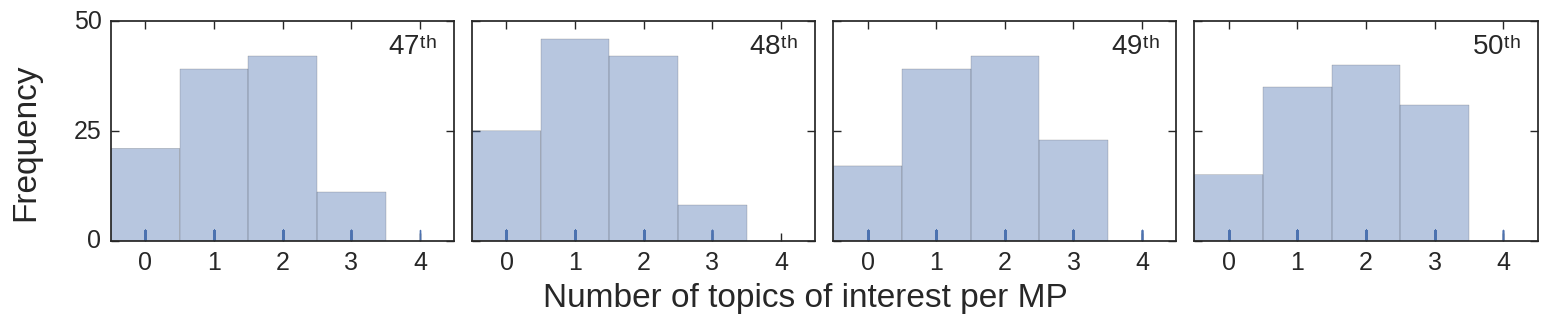

In [34]:
#Bottom nodes
import seaborn as sns
sns.set(color_codes=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"})

fig = plt.figure(figsize=(15,3), dpi=500)
ax = [fig.add_subplot(1,4,i+1) for i in range(4)]

for i in range(4):
    #plt.subplot(4,1,i+1)
    data = deg_bottom_list[i].values()
    bins = np.arange(5) - 0.5
    #ax1.hist(deg_bottom1.values(), bins=range(min(deg_bottom1.values()), max(deg_bottom1.values()) + 1, 1))
    #ax[i].hist(data,bins,color='black')
    sns.distplot(data, bins=bins, kde=False, rug=True, ax=ax[i])
    ax[i].xaxis.set_ticks(np.linspace(0,5,6,endpoint=True))
    ax[i].set_xlim([-0.5,4.5])
    ax[i].yaxis.set_ticks(np.linspace(0,50,3,endpoint=True))
    ax[i].set_ylim([0,50])
    ax[i].text(.95,.85,parl_text[i], horizontalalignment='right', transform=ax[i].transAxes,fontsize=20)
    #if not i == 3:   
        #ax[i].xaxis.set_ticklabels([])
    if not i == 0:   
        ax[i].yaxis.set_ticklabels([])
    ax[i].tick_params(axis='both', which='major', labelsize=18)
    
# Set common labels
fig.text(0.5, -0.02, 'Number of topics of interest per MP', ha='center', va='center', fontsize=24)
fig.text(-0.02, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=24)

plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

#plt.savefig("graphs/byyear_standardstop_150plus_bottomdegree.eps", format='eps', dpi=1000)
#plt.savefig("graphs/DD-bottom-1x4.eps", bbox_inches='tight', format='eps', dpi=500)

plt.show()
sns.reset_orig()

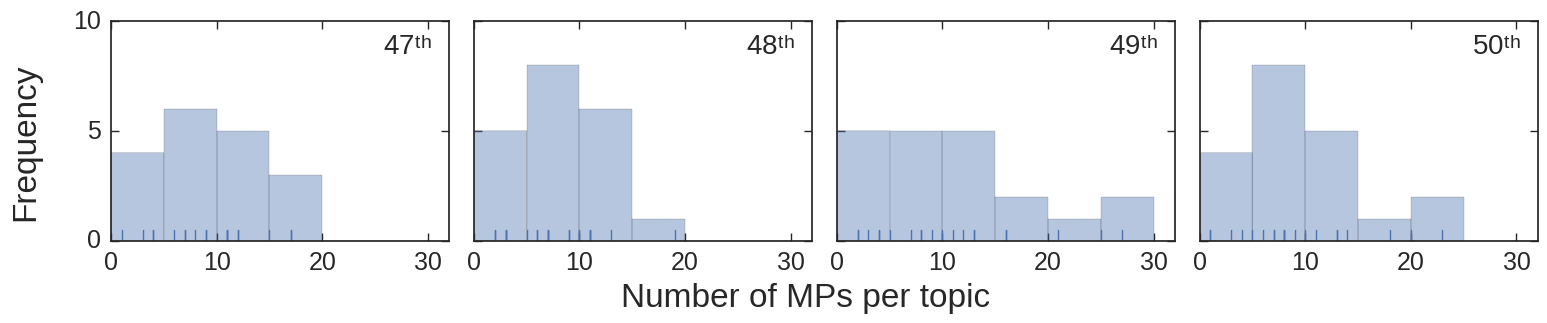

In [35]:
#Top nodes
import seaborn as sns
sns.set(color_codes=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"})

fig = plt.figure(figsize=(15,3), dpi=500)
ax = [fig.add_subplot(1,4,i+1) for i in range(4)]

for i in range(4):
    #plt.subplot(4,1,i+1)
    data = deg_top_list[i].values()
    bins = np.arange(0,55,5) #- 0.5
    #ax1.hist(deg_bottom1.values(), bins=range(min(deg_bottom1.values()), max(deg_bottom1.values()) + 1, 1))
    #ax[i].hist(data,bins,color='black')
    sns.distplot(data, bins=bins, kde=False, rug=True, ax=ax[i])
    
    ax[i].xaxis.set_ticks(np.linspace(0,50,6,endpoint=True))
    ax[i].set_xlim([0,32])
    ax[i].yaxis.set_ticks(np.linspace(0,20,5,endpoint=True))
    ax[i].set_ylim([0,10])
    ax[i].text(.95,.85,parl_text[i], horizontalalignment='right', transform=ax[i].transAxes, fontsize=20)
    #if not i == 3:   
        #ax[i].xaxis.set_ticklabels([])
    if not i == 0:   
        ax[i].yaxis.set_ticklabels([])
    ax[i].tick_params(axis='both', which='major', labelsize=18)
    
    
# Set common labels
fig.text(0.5, -0.02, 'Number of MPs per topic', ha='center', va='center', fontsize=24)
fig.text(-0.02, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=24)

plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

#plt.savefig("graphs/byyear_standardstop_150plus_topdegree.eps", format='eps', dpi=1000)
#plt.savefig("graphs/DD-top-1x4.eps", bbox_inches='tight', format='eps', dpi=500)

plt.show()
sns.reset_orig()

### Bottom nodes degree distribution by party

In [ ]:
#Bottom nodes
import seaborn as sns
sns.set(color_codes=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"})
party_colors = ['b','r','g','y']


for j in range(len(party_node_list_four)):

    fig = plt.figure(figsize=(15,3), dpi=500)
    ax = [fig.add_subplot(1,4,i+1) for i in range(4)]


    for i in range(4):
        #plt.subplot(4,1,i+1)
        #data = deg_bottom_list[i].values()
        data = B[i].degree(party_node_list_four[j]).values()
        bins = np.arange(5) - 0.5
        #ax1.hist(deg_bottom1.values(), bins=range(min(deg_bottom1.values()), max(deg_bottom1.values()) + 1, 1))
        #ax[i].hist(data,bins,color='black')
        sns.distplot(data, bins=bins, kde=False, rug=True, ax=ax[i], color=party_colors[j])
        ax[i].xaxis.set_ticks(np.linspace(0,5,6,endpoint=True))
        ax[i].set_xlim([-0.5,4.5])
        ax[i].yaxis.set_ticks(np.linspace(0,50,6,endpoint=True))
        ax[i].set_ylim([0,30])
        ax[i].text(.95,.85,parl_text[i], horizontalalignment='right', transform=ax[i].transAxes,fontsize=18)
        #if not i == 3:   
            #ax[i].xaxis.set_ticklabels([])
        if not i == 0:   
            ax[i].yaxis.set_ticklabels([])
        ax[i].tick_params(axis='both', which='major', labelsize=16)

    # Set common labels
    fig.text(0.5, 0, 'Number of topics of interest per MP', ha='center', va='center', fontsize=20)
    fig.text(0, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=20)

    plt.tight_layout()
    plt.rcParams.update({'figure.autolayout': True})

    #plt.savefig("graphs/byyear_standardstop_150plus_bottomdegree.eps", format='eps', dpi=1000)
    #plt.savefig("graphs/DD-bottom-1x4.eps", bbox_inches='tight', format='eps', dpi=500)

    plt.show()
sns.reset_orig()

## Average degree

In [36]:
def av_degree_bottom(B,National,Labour,Greens,others):
    
   
    av_degree_b = []
    av_degree_b_National = []
    av_degree_b_Labour = []
    av_degree_b_Greens = []
    av_degree_b_others = []
    
    for i in range(len(B)):
        
        top_nodes = set(node for node,d in B[i].nodes(data=True) if d['bipartite']==0) #dlist
        bottom_nodes = set(B[i]) - top_nodes #klist
        deg_top, deg_bottom = bipartite.degrees(B[i],bottom_nodes) #dictionary
        
        #average degree for the bottom nodes
        av_degree_b.append(sum(deg_bottom.values())/float(len(deg_bottom.values())))
        
        #average degree by party
        av_degree_b_National.append(sum(B[i].degree(National).values())/float(len(B[i].degree(National).values())))    
        av_degree_b_Labour.append(sum(B[i].degree(Labour).values())/float(len(B[i].degree(Labour).values())))
        av_degree_b_Greens.append(sum(B[i].degree(Greens).values())/float(len(B[i].degree(Greens).values())))
        av_degree_b_others.append(sum(B[i].degree(others).values())/float(len(B[i].degree(others).values())))
        
    return av_degree_b, av_degree_b_National, av_degree_b_Labour, av_degree_b_Greens, av_degree_b_others

In [37]:
av_degree_b, av_degree_b_National, av_degree_b_Labour, av_degree_b_Greens, \
av_degree_b_others = av_degree_bottom(B,National,Labour,Greens,others)

In [38]:
print av_degree_b, av_degree_b_National, av_degree_b_Labour, av_degree_b_Greens, av_degree_b_others

[1.4260869565217391, 1.2727272727272727, 1.7007874015748032, 1.792] [1.0, 1.2708333333333333, 1.9827586206896552, 2.0327868852459017] [1.5, 1.3, 1.3191489361702127, 1.4615384615384615] [2.125, 1.7142857142857142, 2.1818181818181817, 1.7857142857142858] [1.4827586206896552, 1.0, 1.3636363636363635, 1.6363636363636365]


In [ ]:
for i in range(4):
    print len(B[i].degree(National).values()), len(B[i].degree(Labour).values()), \
        len(B[i].degree(Greens).values()), len(B[i].degree(others).values())
        
with open('MPs_perparty_perterm.csv','w') as outcsv:
    writer = csv.writer(outcsv)
    writer.writerow(['Term','National','Labour','Greens','Others'])
    for i in range(len(B)):
        writer.writerow([parl_text_test[i], \
                        len(B[i].degree(National).values()), \
                        len(B[i].degree(Labour).values()), \
                        len(B[i].degree(Greens).values()), \
                        len(B[i].degree(others).values())])

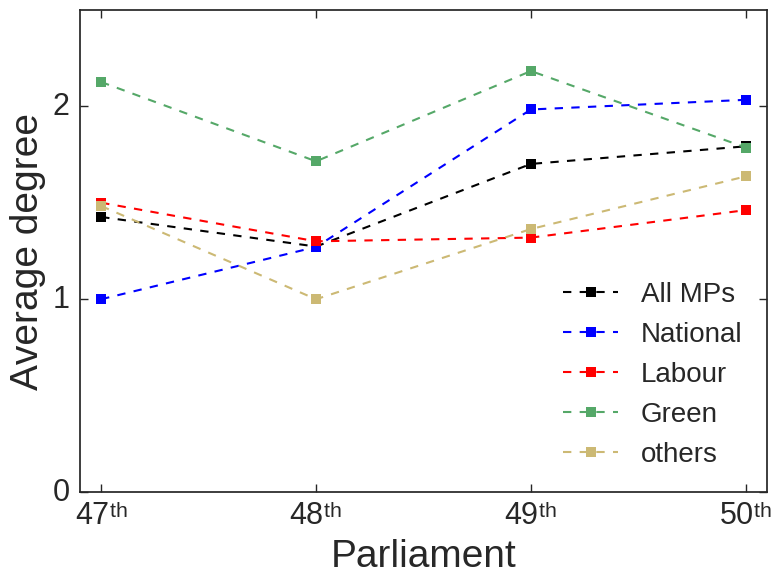

In [39]:
#Set figure and number of plots
import seaborn as sns
sns.set(color_codes=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"})

plt.figure(figsize=(8,6), dpi=500)
plt.subplot(111)

#x axis values
x = range(1,5,1)

#plot average degree of the whole network 
plt.plot(x,av_degree_b, color='black', marker='s', linewidth=1.5, linestyle='--', label='All MPs')

#plot average degree for National, Labour and Greens
plt.plot(x,av_degree_b_National, color='blue', marker='s', linewidth=1.5, linestyle='--', label='National')
plt.plot(x,av_degree_b_Labour, color='red', marker='s', linewidth=1.5, linestyle='--', label='Labour')
plt.plot(x,av_degree_b_Greens, 'g--', marker='s', linewidth=1.5, label='Green')
plt.plot(x,av_degree_b_others, 'y--', marker='s', linewidth=1.5, label='others')

# Set axis ticks
plt.xticks(np.linspace(1,4,4,endpoint=True), parl_text, fontsize=18)
plt.yticks(np.linspace(0,5,6,endpoint=True))

#Set axis limits
plt.xlim(0.9, 4.1)
plt.ylim(0, 2.5)

#Set axis label
plt.xlabel('Parliament', fontsize=28)
plt.ylabel('Average degree', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=22)

#Set legend
plt.legend(loc='lower right', frameon=False, fontsize=20)

plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

# Save figure using 72 dots per inch
#plt.savefig("graphs/byyear_standardstop_150plus_averagedegree.eps", format='eps', dpi=500)
#plt.savefig("graphs/averagedegree.eps", format='eps', dpi=500)

#plt.plot(x, av_degree, 'k--', x, av_degree_National, 'b--', x, av_degree_Labour, 'r--', x, av_degree_Greens, 'g--')
plt.show()
sns.reset_orig()

In [40]:
def av_degree(Gw,National,Labour,Greens,others):
    
   
    av_degree = []
    av_degree_National = []
    av_degree_Labour = []
    av_degree_Greens = []
    av_degree_others = []
    
    for G in Gw:
        #average degree for the whole network
        av_degree.append(sum(G.degree().values())/float(len(G.degree().values())))
        
        #average degree by party
        av_degree_National.append(sum(G.degree(National).values())/float(len(G.degree(National).values())))    
        av_degree_Labour.append(sum(G.degree(Labour).values())/float(len(G.degree(Labour).values())))
        av_degree_Greens.append(sum(G.degree(Greens).values())/float(len(G.degree(Greens).values())))
        av_degree_others.append(sum(G.degree(others).values())/float(len(G.degree(others).values())))
        
    return av_degree, av_degree_National, av_degree_Labour, av_degree_Greens, av_degree_others

In [41]:
av_degree, av_degree_National, av_degree_Labour, \
av_degree_Greens, av_degree_others = av_degree(Gw,National,Labour,Greens, others)

In [42]:
print av_degree, av_degree_National, av_degree_Labour, av_degree_Greens, av_degree_others

[13.756521739130434, 10.958677685950413, 22.078740157480315, 24.992] [10.038461538461538, 10.333333333333334, 28.75862068965517, 33.34426229508197] [14.73076923076923, 12.02, 14.425531914893616, 16.846153846153847] [18.625, 12.857142857142858, 20.636363636363637, 18.0] [14.0, 8.6875, 21.0, 16.454545454545453]


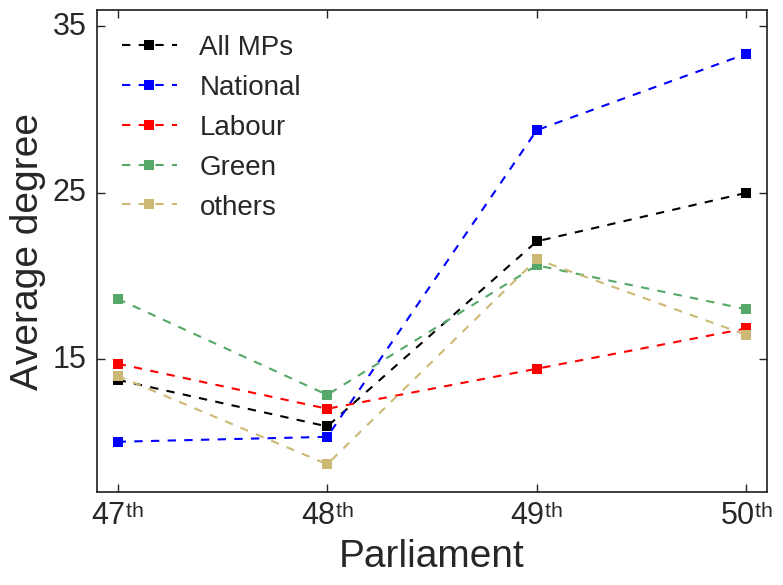

In [43]:
#Set figure and number of plots
import seaborn as sns
sns.set(color_codes=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"})

plt.figure(figsize=(8,6), dpi=500)
plt.subplot(111)

#x axis values
x = range(1,5,1)

#plot average degree of the whole network 
plt.plot(x,av_degree, color='black', marker='s', linewidth=1.5, linestyle='--', label='All MPs')

#plot average degree for National, Labour and Greens
plt.plot(x,av_degree_National, color='blue', marker='s', linewidth=1.5, linestyle='--', label='National')
plt.plot(x,av_degree_Labour, color='red', marker='s', linewidth=1.5, linestyle='--', label='Labour')
plt.plot(x,av_degree_Greens, 'g--', marker='s', linewidth=1.5, label='Green')
plt.plot(x,av_degree_others, 'y--', marker='s', linewidth=1.5, label='others')

# Set axis ticks
plt.xticks(np.linspace(1,4,4,endpoint=True), parl_text, fontsize=18)
plt.yticks(np.linspace(5,45,5,endpoint=True))

#Set axis limits
plt.xlim(0.9, 4.1)
plt.ylim(7, 36)

#Set axis label
plt.xlabel('Parliament', fontsize=28)
plt.ylabel('Average degree', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=22)

#Set legend
plt.legend(loc='upper left', frameon=False, fontsize=20)

plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

# Save figure using 72 dots per inch
#plt.savefig("graphs/byyear_standardstop_150plus_averagedegree.eps", format='eps', dpi=500)
#plt.savefig("graphs/averagedegree.eps", format='eps', dpi=500)

#plt.plot(x, av_degree, 'k--', x, av_degree_National, 'b--', x, av_degree_Labour, 'r--', x, av_degree_Greens, 'g--')
plt.show()
sns.reset_orig()

## Incomplete properties

In [ ]:
for G in G_list:
    print G.degree(Greens)

In [ ]:
#incomplete at the moment: we should review the importance of this metric
def top_betweenness(G_list):
    for G in G_list:
        bc = nx.betweenness_centrality(G,weight='weight')
      
        
    return bc

In [ ]:
sorted_bc = sorted(bc.items(), key=operator.itemgetter(1))
print sorted_bc

In [ ]:
#incomplete at the moment: we should review the importance of this metric
def shortest_path(G_list):
    
    for G in G_list:
        LCC = max(nx.connected_component_subgraphs(G), key=len)
        av_sp = nx.average_shortest_path_length(LCC,weight='weight')

## Clustering coefficient

In [44]:
def av_clustering(G_list,National,Labour,Greens):
    
    av_c = []
    av_c_National = []
    av_c_Labour = []
    av_c_Greens = []
    
    for G in G_list:
        #average clustering for the whole network
        av_c.append(nx.average_clustering(G))#,weight='weight'))
        
        #average clustering by party
        av_c_National.append(nx.average_clustering(G,nodes=National))#,weight='weight'))
        av_c_Labour.append(nx.average_clustering(G,nodes=Labour))#,weight='weight'))
        av_c_Greens.append(nx.average_clustering(G,nodes=Greens))#,weight='weight'))
        
            
    return av_c, av_c_National, av_c_Labour, av_c_Greens

In [45]:
av_c, av_c_National, av_c_Labour, av_c_Greens = av_clustering(Gw,National,Labour,Greens)

In [46]:
print av_c, av_c_National, av_c_Labour, av_c_Greens 

[0.623823386108453, 0.60575582173927, 0.6611130510128117, 0.6717719135630189] [0.5774676001628848, 0.6423573548227215, 0.6382603129902414, 0.6665058170384417] [0.5492482451403897, 0.5949733523026444, 0.7090797065872082, 0.6503696195258561] [0.6080302974459321, 0.693859339834572, 0.6614753221258524, 0.8002519429937325]


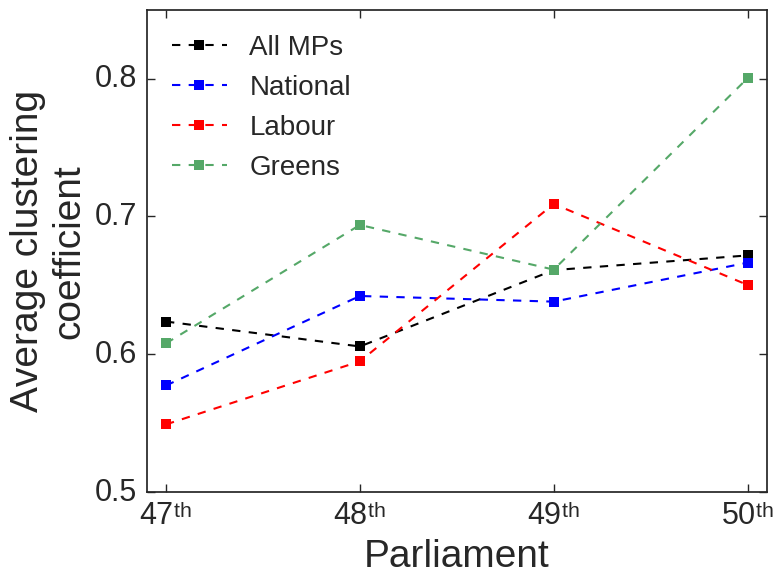

In [47]:
#Set figure and number of plots
import seaborn as sns
sns.set(color_codes=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"})

plt.figure(figsize=(8,6), dpi=500)
plt.subplot(111)

#x axis values
x = range(1,5,1)

#plot average degree of the whole network 
plt.plot(x,av_c, color='black', marker='s', linewidth=1.5, linestyle='--', label='All MPs')

#plot average degree for National, Labour and Greens
plt.plot(x,av_c_National, color='blue', marker='s', linewidth=1.5, linestyle='--', label='National')
plt.plot(x,av_c_Labour, color='red', marker='s', linewidth=1.5, linestyle='--', label='Labour')
plt.plot(x,av_c_Greens, 'g--', marker='s', linewidth=1.5, label='Greens')

# Set axis ticks
plt.xticks(np.linspace(1,4,4,endpoint=True), parl_text, fontsize=18)
plt.yticks(np.linspace(0,1,11,endpoint=True))

#Set axis limits
plt.xlim(0.9, 4.1)
plt.ylim(0.50, 0.85)

#Set axis label
plt.xlabel('Parliament', fontsize=28)
plt.ylabel('Average clustering\ncoefficient', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=22)

#Set legend
plt.legend(loc='upper left', frameon=False, fontsize=20)

plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

# Save figure using 72 dots per inch
#plt.savefig("graphs/byyear_standardstop_150plus_clustering.eps", format='eps', dpi=500)
#plt.savefig("graphs/clustering.eps", format='eps', dpi=500)

#plt.plot(x, av_degree, 'k--', x, av_degree_National, 'b--', x, av_degree_Labour, 'r--', x, av_degree_Greens, 'g--')
plt.show()
sns.reset_orig()

In [ ]:
#transitivity
for G in Gw:
    print(nx.transitivity(G))

## Community structure

In [99]:
def communities(Gprime):
    comm = community.best_partition(Gprime)
    commlist = comm.values()
    #ncomm = max(commlist)
    #print 'Number of communities : ', ncomm
    
    #commsizes = []
    #for comm in commlist:
        #commsizes.append(commlist.count(comm))
    #print 'Communitites sizes: ', commsizes, len(commsizes), sum(commsizes)
    
    commsizesdict = Counter(commlist)
    commsizeslist = commsizesdict.values()
    print 'Communitites sizes: ', sorted(commsizeslist, reverse=True) 
    print 'Number of communities: ', len(commsizeslist)
    print 'Number of nodes confirmed: ', sum(commsizeslist)
    print ' '
    return comm

In [100]:
for G in Gw:
    communities(G)

Communitites sizes:  [19, 17, 17, 16, 16, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of communities:  27
Number of nodes confirmed:  115
 
Communitites sizes:  [24, 19, 17, 15, 10, 9, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of communities:  32
Number of nodes confirmed:  121
 
Communitites sizes:  [30, 24, 22, 18, 16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of communities:  22
Number of nodes confirmed:  127
 
Communitites sizes:  [48, 24, 21, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of communities:  19
Number of nodes confirmed:  125
 


In [101]:
commun = []
for G in Gw:
    commun.append(community.best_partition(G))

In [102]:
mp_in_comm = []
for c in commun:
    new_dict = defaultdict(list)
    for k, v in c.iteritems():
        new_dict[v].append(k)
    mp_in_comm.append(new_dict)

In [106]:
print commun[3].values()
counter=collections.Counter(commun[3].values())
print counter

[0, 0, 1, 3, 1, 2, 1, 0, 2, 9, 0, 1, 3, 2, 2, 4, 2, 3, 2, 0, 1, 3, 0, 2, 2, 0, 5, 0, 2, 6, 2, 0, 3, 0, 2, 3, 1, 2, 12, 0, 3, 13, 0, 2, 2, 1, 1, 1, 0, 0, 3, 1, 0, 11, 1, 0, 0, 3, 0, 1, 0, 10, 2, 3, 1, 1, 14, 7, 15, 1, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 8, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 16, 17, 0, 3, 1, 18, 0, 1, 0, 3, 1, 3, 3, 0, 2, 2, 0, 3, 0, 0, 0, 0, 1, 1, 3, 0, 0, 2]
Counter({0: 48, 1: 24, 2: 21, 3: 17, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1})


In [107]:
fractions = {'National':[], 'Labour':[], 'Greens':[], 'others': []} #National, Labour, Greens
keys_top_comm = [[4,0,2],[3,0,9],[2,0,1],[0,1,2]]
size_top_comm = []

for i in range(len(B)):           # i is each dictionary of communities for that each term
    for com in keys_top_comm[i]:             # coms is the set (list) of top three communities
        cNational = 0
        cLabour = 0
        cGreens = 0
        cothers = 0
        
        for MP in mp_in_comm[i][com]:
            if B[i].node[MP]['party'] == 'National':
                cNational += 1
            elif B[i].node[MP]['party'] == 'Labour':
                cLabour += 1
            elif B[i].node[MP]['party'] == 'Greens':
                cGreens += 1
            else:
                cothers += 1
                
        fractions['National'].append(cNational)
        fractions['Labour'].append(cLabour)
        fractions['Greens'].append(cGreens)
        fractions['others'].append(cothers)
        size_top_comm.append(len(mp_in_comm[i][com]))

In [108]:
print fractions

{'National': [4, 2, 4, 9, 4, 10, 20, 9, 10, 34, 12, 5], 'Labour': [7, 8, 7, 10, 14, 5, 7, 8, 8, 9, 9, 9], 'Greens': [2, 1, 1, 2, 0, 0, 1, 5, 2, 3, 2, 3], 'others': [6, 6, 5, 3, 1, 2, 2, 2, 2, 2, 1, 4]}


In [109]:
print [fractions['National'][j*3] for j in range(4)]
print [fractions['National'][j*3+1] for j in range(4)]
print [fractions['National'][j*3+2] for j in range(4)]

[4, 9, 20, 34]
[2, 4, 9, 12]
[4, 10, 10, 5]


In [110]:
with open('top_community_proportion.csv','w') as outcsv:
    writer = csv.writer(outcsv)
    writer.writerow(['Term','Size','National','Labour','Greens','Others'])
    for i in range(len(B)):
        writer.writerow([parl_text_test[i], size_top_comm[i*3], \
                        fractions['National'][i*3], \
                        fractions['Labour'][i*3], \
                        fractions['Greens'][i*3], \
                        fractions['others'][i*3]])

In [111]:
for i in range(len(B)):
    for com in keys_top_comm[i]:
            
        cNational = 0
        cLabour = 0
        cGreens = 0
        cothers = 0

        for MP in mp_in_comm[i][com]:
            if B[i].node[MP]['party'] == 'National':
                cNational += 1
            elif B[i].node[MP]['party'] == 'Labour':
                cLabour += 1
            elif B[i].node[MP]['party'] == 'Greens':
                cGreens += 1
            else:
                cothers += 1

        print i, com, cNational, cLabour, cGreens, cothers

0 4 4 7 2 6
0 0 2 8 1 6
0 2 4 7 1 5
1 3 9 10 2 3
1 0 4 14 0 1
1 9 10 5 0 2
2 2 20 7 1 2
2 0 9 8 5 2
2 1 10 8 2 2
3 0 34 9 3 2
3 1 12 9 2 1
3 2 5 9 3 4


In [112]:
df_com = pd.read_csv('top_community_proportion.csv')

In [113]:
print df_com

     Term  Size  National  Labour  Greens  Others
0  $47th$    19         4       7       2       6
1  $48th$    24         9      10       2       3
2  $49th$    30        20       7       1       2
3  $50th$    48        34       9       3       2


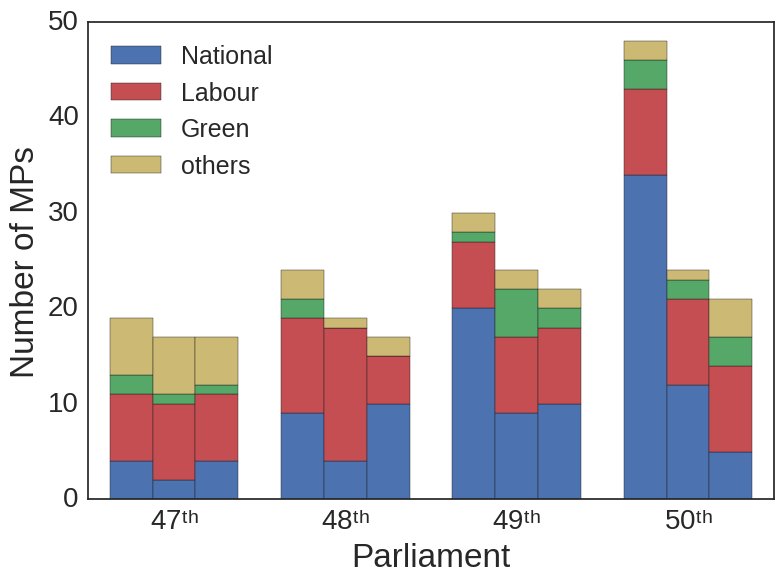

In [115]:
# Create the general blog and the "subplots" i.e. the bars
#Set figure and number of plots
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("white")
fig = plt.figure(figsize=(8,6), dpi=500)
ax1 = fig.add_subplot(1,1,1)

# Set the bar width
bar_width = 0.25
opacity = 1.0

# positions of the left bar-boundaries
bar_l1 = [i+1 for i in range(4)]
bar_l2 = [p + bar_width for p in bar_l1]
bar_l3 = [p + bar_width for p in bar_l2]
bar_l = [bar_l1, bar_l2, bar_l3]

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos1 = [i+(bar_width/2) for i in bar_l1]
tick_pos2 = [i+(bar_width/2) for i in bar_l2]
tick_pos3 = [i+(bar_width/2) for i in bar_l3]
tick_pos = [tick_pos1, tick_pos2, tick_pos3]

for z in range(3):
    # Create a bar plot, in position bar_1
    ax1.bar(bar_l[z], [fractions['National'][j*3+z] for j in range(4)], width=bar_width, bottom=0, \
            label='National', alpha=opacity, color='b')

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l[z], [fractions['Labour'][j*3+z] for j in range(4)], width=bar_width, \
            bottom=[fractions['National'][j*3+z] for j in range(4)], label='Labour',   \
            alpha=opacity, color='r')

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l[z], [fractions['Greens'][j*3+z] for j in range(4)], width=bar_width,   \
            bottom=[i+j for i,j in zip([fractions['National'][j*3+z] for j in range(4)], \
                                       [fractions['Labour'][j*3+z] for j in range(4)])], \
            label='Green', alpha=opacity, color='g')

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l[z], [fractions['others'][j*3+z] for j in range(4)], width=bar_width,       \
            bottom=[i+j+k for i,j,k in zip([fractions['National'][j*3+z] for j in range(4)], \
                                       [fractions['Labour'][j*3+z] for j in range(4)],       \
                                          [fractions['Greens'][j*3+z] for j in range(4)])],  \
            label='others', alpha=opacity, color='y')

# set the x ticks with names
plt.xticks(tick_pos2, parl_text)
plt.yticks(np.linspace(0,50,6,endpoint=True))
    
# set tick limist
ax1.set_ylim(0,50)
ax1.set_xlim(min(tick_pos[0])-bar_width, max(tick_pos[2])+bar_width)

# Set the label and legends
ax1.set_ylabel("Number of MPs", fontsize=24)
ax1.set_xlabel("Parliament", fontsize=24)
ax1.tick_params(axis='both', which='major', labelsize=20)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=18)

plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

# Save figure using 72 dots per inch
#plt.savefig("graphs/byyear_standardstop_150plus_words.eps", format='eps', dpi=500)
plt.savefig("graphs/Fig8.eps", format='eps', dpi=500)

plt.show()
sns.reset_orig()

## Homophily

In [68]:
def av_homophily(Gm_list,National,Labour,Greens):
    
    av_h = []
    av_h_National = []
    av_h_Labour = []
    av_h_Greens = []
    
    for G in Gm_list:
        #average clustering for the whole network
        av_h.append(nx.attribute_assortativity_coefficient(G,'party'))
        
        #average clustering by party
        av_h_National.append(nx.attribute_assortativity_coefficient(G,'party',nodes=National))
        av_h_Labour.append(nx.attribute_assortativity_coefficient(G,'party',nodes=Labour))
        av_h_Greens.append(nx.attribute_assortativity_coefficient(G,'party',nodes=Greens))
        
            
    return av_h, av_h_National, av_h_Labour, av_h_Greens

In [69]:
av_h_CM100 = []
for i in range(5):
    Gm_CM = conf_model(Gm)
    av_h_CM, av_h_CM_National, av_h_CM_Labour, av_h_CM_Greens = av_homophily(Gm_CM,National,Labour,Greens)
    av_h_CM100.append(av_h_CM)
    
a = np.array(av_h_CM100)
av_h_CM = np.mean(a, axis=0)        
sd_h_CM = np.std(a, axis=0)

In [70]:
print av_h_CM
print sd_h_CM

[-0.01536147 -0.01221924 -0.01870998 -0.00082111]
[ 0.01219323  0.02419418  0.00815173  0.01397379]


In [71]:
av_h, av_h_National, av_h_Labour, av_h_Greens = av_homophily(Gm,National,Labour,Greens)

In [72]:
print av_h, av_h_National, av_h_Labour, av_h_Greens
print av_h_CM, av_h_CM_National, av_h_CM_Labour, av_h_CM_Greens

[0.0019006559812673116, 0.024366405051166513, 0.07294839179284657, 0.10904734034917235] [0.0, 0.0, 0.0, 0.0] [2.314815006343451e-16, 0.0, 0.0, 0.0] [0.0, -1.5153906226923834e-17, 0.0, 0.0]
[-0.01536147 -0.01221924 -0.01870998 -0.00082111] [-1.5670335399657157e-17, 8.79638242587624e-17, 0.0, 0.0] [1.0891761426417412e-16, 0.0, -3.5984860315701347e-17, 0.0] [0.0, 3.544058714361219e-18, 0.0, 0.0]


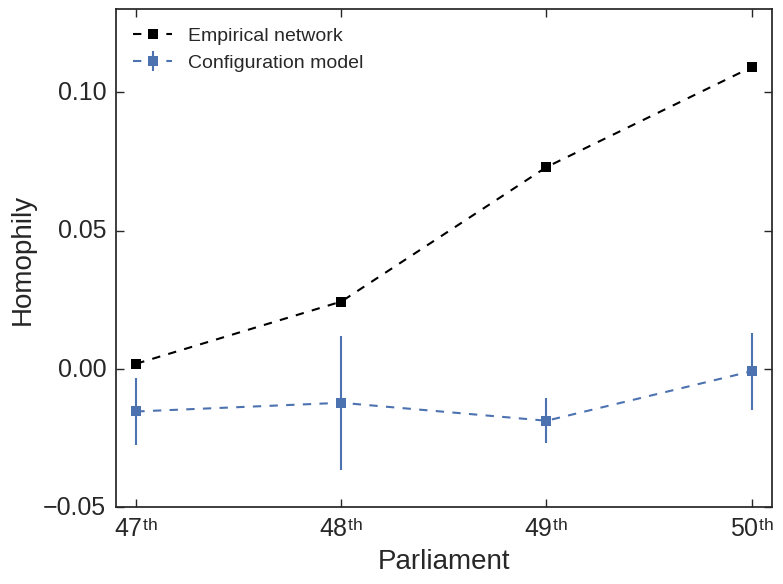

In [73]:
#Set figure and number of plots
import seaborn as sns
sns.set(color_codes=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"})

plt.figure(figsize=(8,6), dpi=500)
plt.subplot(111)

#x axis values
x = range(1,5,1)

#plot average degree of the whole network 
plt.plot(x,av_h, color='black', marker='s', linewidth=1.5, linestyle='--', label='Empirical network')
#plt.plot(x,av_h_CM, color='gray', marker='s', linewidth=1.5, linestyle='--', label='Configuration model')
plt.errorbar(x, av_h_CM, yerr=sd_h_CM, marker='s', \
            linewidth=1.5, linestyle='--', label='Configuration model')

#plot average degree for National, Labour and Greens
#plt.plot(x,av_h_National, color='blue', marker='s', linewidth=1.5, linestyle='--', label='National')
#plt.plot(x,av_h_Labour, color='red', marker='s', linewidth=1.5, linestyle='--', label='Labour')
#plt.plot(x,av_h_Greens, 'g--', marker='s', linewidth=1.5, label='Greens')

# Set axis ticks
plt.xticks(np.linspace(1,4,4,endpoint=True), parl_text, fontsize=18)
plt.yticks(np.linspace(-0.05,0.20,6,endpoint=True))

#Set axis limits
plt.xlim(0.9, 4.1)
plt.ylim(-0.05, 0.13)

#Set axis label
plt.xlabel('Parliament', fontsize=20)
plt.ylabel('Homophily', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)

#Set legend
plt.legend(loc='upper left', frameon=False, fontsize=14)

plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

# Save figure using 72 dots per inch
#plt.savefig("graphs/byyear_standardstop_150plus_homophily.eps", format='eps', dpi=500)
#plt.savefig("graphs/homophily_confmodel.eps", format='eps', dpi=500)

#plt.plot(x, av_degree, 'k--', x, av_degree_National, 'b--', x, av_degree_Labour, 'r--', x, av_degree_Greens, 'g--')
plt.show()
sns.reset_orig()

## Words spoken per party

In [74]:
def get_words_party(Gw):
    
    w = []
    w_National = []
    w_Labour = []
    w_Greens = []
    w_others = []
    
    for G in Gw:
        #words for the whole network
        words_N = 0
        words_L = 0
        words_G = 0
        words_others = 0
        for node in G.nodes():
            if G.node[node]['party'] == 'National':
                words_N += G.node[node]['words']
            if G.node[node]['party'] == 'Labour':
                words_L += G.node[node]['words']
            if G.node[node]['party'] == 'Greens':
                words_G += G.node[node]['words']
            if G.node[node]['party'] not in ['National','Labour','Greens']:
                words_others += G.node[node]['words']
        w.append(words_N+words_L+words_G+words_others)
        w_National.append(words_N)
        w_Labour.append(words_L)
        w_Greens.append(words_G)
        w_others.append(words_others)
        
            
    return w, w_National, w_Labour, w_Greens, w_others

In [75]:
w, w_National, w_Labour, w_Greens, w_others = get_words_party(Gw)

In [76]:
print w_National

[2493620, 4014700, 3171585, 3395512]


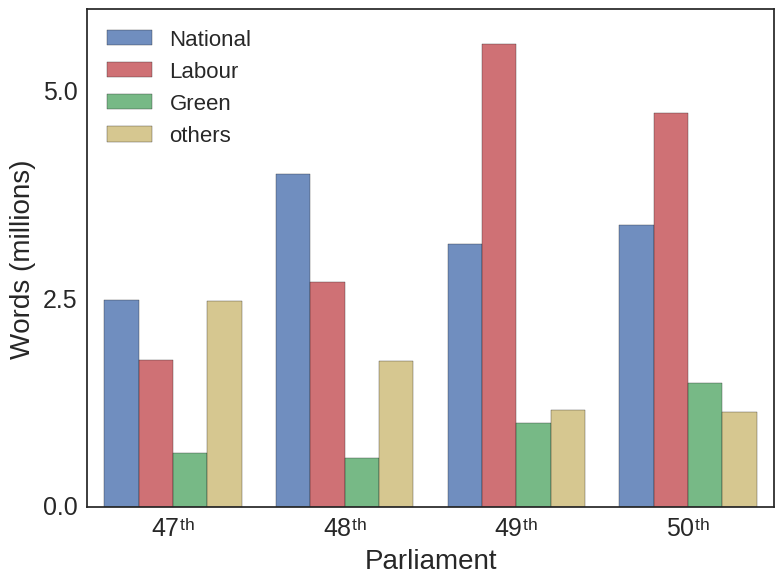

In [77]:
#Set figure and number of plots
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,6), dpi=500)

# Setting the positions and width for the bars
pos = [0, 1.25, 2.50, 3.75]
width = 0.25
opacity= 0.8

plt.bar(pos, [w/float(1e6) for w in w_National], width, alpha=opacity, color='b', label='National')
plt.bar([p + width for p in pos], [w/float(1e6) for w in w_Labour], width, alpha=opacity, color='r', label='Labour')
plt.bar([p + width*2 for p in pos], [w/float(1e6) for w in w_Greens], width, alpha=opacity, color='g', label='Green')
plt.bar([p + width*3 for p in pos], [w/float(1e6) for w in w_others], width, alpha=opacity, color='y', label='others')

# Set axis ticks
#plt.xticks([p + 1.5 * width for p in pos])
plt.xticks([p + 2 * width for p in pos])
plt.yticks(np.linspace(0,10,5,endpoint=True))

#Set axis limits
plt.xlim(min(pos)-width/2, max(pos)+width*4+width/2)
plt.ylim([0, 6])

#Set axis label
ax.set_xticklabels(parl_text,fontsize=18)
plt.xlabel('Parliament', fontsize=20)
#plt.ylabel('Words ' + r'($\times$ ' + '$\mathregular{10^{6}}$)', fontsize=24)
plt.ylabel('Words ' + r'(millions)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)

#Set legend
plt.legend(loc='upper left', frameon=False, fontsize=16)

plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

# Save figure using 72 dots per inch
#plt.savefig("graphs/byyear_standardstop_150plus_words.eps", format='eps', dpi=500)
#plt.savefig("graphs/words-per-party.eps", format='eps', dpi=500)

plt.show()
sns.reset_orig()

## Speech size histogram per politician

In [ ]:
#Bottom nodes
import seaborn as sns
sns.set(color_codes=True)

sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"})
party_colors = ['b','r','g','y']


fig = plt.figure(figsize=(12,8), dpi=500)
ax = [fig.add_subplot(2,2,i+1) for i in range(4)]


for i in range(4):

    top_nodes = set(node for node,d in B[i].nodes(data=True) if d['bipartite']==0) #dlist
    bottom_nodes = set(B[i]) - top_nodes #klist
    deg_top, deg_bottom = bipartite.degrees(B[i],bottom_nodes) #dictionary

    data = [B[i].node[node]['words']/float(1000) for node in deg_bottom.keys()]
    ax[i].hist(data, bins=range(0, 300, 10))
    #ax[i].xaxis.set_ticks(np.linspace(0,5,6,endpoint=True))
    ax[i].set_xlim([0,295])
    #ax[i].yaxis.set_ticks(np.linspace(0,50,6,endpoint=True))
    ax[i].set_ylim([0,20])
    ax[i].text(.95,.85,parl_text[i], horizontalalignment='right', transform=ax[i].transAxes,fontsize=18)
    #if not i == 3:   
        #ax[i].xaxis.set_ticklabels([])
    if i == 1 or i == 3:   
        ax[i].yaxis.set_ticklabels([])
    if i == 0 or i == 1:   
        ax[i].xaxis.set_ticklabels([])
    ax[i].tick_params(axis='both', which='major', labelsize=18)

# Set common labels
#fig.text(0.5, -0.02, 'Words spoken ' + r'($\times$ ' + '$\mathregular{10^{3}}$)', ha='center', va='center', fontsize=28)
fig.text(0.5, -0.02, 'Words spoken (thousands)', ha='center', va='center', fontsize=20)
fig.text(-0.02, 0.5, 'Frequency of MPs', ha='center', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

#plt.savefig("graphs/byyear_standardstop_150plus_bottomdegree.eps", format='eps', dpi=1000)
#plt.savefig("graphs/words-spoken-hist.eps", bbox_inches='tight', format='eps', dpi=500)

plt.show()
sns.reset_orig()

## Topic proportions

In [ ]:
topic_prop = []

with open('topicproportions.csv','rb') as csvfile:
    read = csv.reader(csvfile)
    for row in read:
        topic_prop.append(float(row[1]))

In [ ]:
indices = [i for i, x in enumerate(topic_class) if x in x_topics]

topic_prop_n = []
topic_class_n = []

for ind in range(len(topic_class)):
    if not ind in indices:
        topic_prop_n.append(topic_prop[ind])
        topic_class_n.append(topic_class[ind])
        
s = sum(topic_prop_n)
#for i in range(len(topic_class_n)):
    #print topic_class_n[i], topic_prop_n[i]

In [ ]:
print indices

In [ ]:
for i in range(len(topic_prop_n)):
    topic_prop_n[i] = topic_prop_n[i]/s

print sum(topic_prop_n)

In [ ]:
#Set figure and number of plots
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12,5), dpi=500)

topic_prop_n, topic_class_n = (list(t) for t in zip(*sorted(zip(topic_prop_n, topic_class_n))))

# Setting the positions and width for the bars
pos = list(range(len(topic_class_n)))
width = 0.75
opacity= 0.8

plt.barh(pos, topic_prop_n, width, alpha=opacity, color='b', label='National')

# Set axis ticks
plt.xticks(np.linspace(0,0.06,7,endpoint=True), fontsize=12)
plt.yticks([p + 0.45 for p in pos],topic_class_n,fontsize=12)

#Set axis limits
plt.xlim(0.03, 0.064)
plt.ylim(-0.25,21.05)

#Set axis label
#ax.set_xticklabels(parl_text,fontsize=14)
plt.xlabel('Proportion', fontsize=14)
#plt.ylabel('Topics', fontsize=14)

#Set legend
#plt.legend(loc='upper left', frameon=False, fontsize=14)

plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

# Save figure using 72 dots per inch
#plt.savefig("graphs/byyear_standardstop_150plus_topicprophoriz.eps", format='eps', dpi=500)
#plt.savefig("graphs/topicprop-horiz.eps", format='eps', dpi=500)

plt.show()
sns.reset_orig()

In [ ]:
#Set figure and number of plots
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(15,7), dpi=500)

topic_prop_n, topic_class_n = (list(t) for t in zip(*sorted(zip(topic_prop_n, topic_class_n),reverse=True)))

# Setting the positions and width for the bars
pos = list(range(len(topic_class_n)))
width = 0.8
opacity= 0.8

plt.bar(pos, topic_prop_n, width, alpha=opacity, color='b', label='National')

# Set axis ticks
plt.yticks(np.linspace(0,0.08,5,endpoint=True), fontsize=22)
plt.xticks([p+0.55 for p in pos],topic_class_n,fontsize=24, rotation=45, ha='right')

#Set axis limits
plt.ylim(0,0.07)
plt.xlim(0,20.8)

#Set axis label
plt.ylabel('Proportion', fontsize=30)
#plt.ylabel('Topics', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=28)

#Set legend
#plt.legend(loc='upper left', frameon=False, fontsize=14)

plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

# Save figure using 72 dots per inch
#plt.savefig("graphs/byyear_standardstop_150plus_topicpropvert.eps", format='eps', dpi=500)
plt.savefig("graphs/topicprop-vert.eps", format='eps', dpi=500)

plt.show()
sns.reset_orig()

## Network draw

In [78]:
def make_label_size(G_bottom):
    code = {}
    size = []
    for node in G_bottom.nodes():
        code[node] = G_bottom.node[node]['code']
        size.append(max(G_bottom.node[node]['words']/200.0, 200))
        '''if G_bottom.node[node]['party'] == 'National':
            colors.append('#0D4F8B')
        if G_bottom.node[node]['party'] == 'Labour':
            colors.append('#ff1a1a')
        if G_bottom.node[node]['party'] == 'Greens':
            colors.append('#339933')
        if G_bottom.node[node]['party'] == 'First':
            colors.append('#1a1a1a')
        if G_bottom.node[node]['party'] == 'United Future':
            colors.append('#660066')
        if G_bottom.node[node]['party'] == 'ACT':
            colors.append('#ffcc00')
        else:
            colors.append('#b3b3b3')
    return code,color,size'''
    return code,size

In [79]:
party_color = ['#b3b3b3','#339933','#b3b3b3','#0D4F8B','#660066','#b3b3b3','#ff1a1a','#ffcc00','#1a1a1a']
party_list = list(set(mp_party))

In [80]:
print set(mp_party)

set(['Maori', 'Progressive', 'Greens', 'National', 'United Future', 'Mana', 'Labour', 'ACT', 'First'])


## 47th Parliament

In [ ]:
#G_list = [G_bottom_w47,G_bottom_w48,G_bottom_w49,G_bottom_w50]

#pos=nx.spring_layout(G_bottom_w47)

#fruchterman_reingold_layout(G, dim=2, k=None,
                                #pos=None,
                                #fixed=None,
                                #iterations=50,
                                #weight='weight',
                                #scale=1.0,
                                #center=None)
                        
#fig, axs = plt.subplots(2,2, figsize=(15, 15), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.001)

#plt.figure(figsize=(15,15), dpi=80)
#plt.subplot(111)

f = plt.figure(1,figsize=(15,15), dpi=80)
ax = f.add_subplot(1,1,1)

pos=nx.fruchterman_reingold_layout(G_bottom_w47,iterations=100,weight='weight',scale=1.0, k=0.25)

code,size = make_label_size(G_bottom_w47)
weights = [(G_bottom_w47[u][v]['weight']/float(2)) for u,v in G_bottom_w47.edges()]

color_map_me = {'Maori':'#660000', 'Greens':'#339933', 'Progressive':'#e6e6e6', 'National':'#0D4F8B', \
                 'United Future':'#660066', 'Mana':'#e6e6e6', 'Labour':'#ff1a1a', 'ACT':'#ffcc00', 'First':'#1a1a1a'}

#wikipedia coloar map for nz parties
color_map = {'National':'#00529F', 'Labour':'#d82a20', 'Greens':'#098137', 'Maori':'#EF4A42', 'Progressive':'#9E9E9E', \
                 'United Future':'#501557', 'Mana':'#770808', 'ACT':'#FDE401', 'First':'#1a1a1a'}

nx.draw_networkx_nodes(G_bottom_w47, pos=pos, node_size=size, alpha=0.9, \
                       node_color=[color_map[G_bottom_w47.node[node]['party']] for node in G_bottom_w47])
nx.draw_networkx_edges(G_bottom_w47, pos=pos, width=weights, alpha=0.5, edge_color='#808080')
nx.draw_networkx_labels(G_bottom_w47, pos=pos, labels=code, font_size=12)

#plt.legend(loc='upper right', frameon=False)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
lgnd = plt.legend(markers, color_map.keys(), numpoints=1,loc='upper left', frameon=False, fontsize=16)
for i in range(len(color_map)):
    lgnd.legendHandles[i]._legmarker.set_markersize(12)

#nx.draw_networkx(G_bottom_w47,pos=pos,labels=codes,font_size=8,node_color=colors,node_size=size)

plt.axis('off')
plt.savefig("graphs/byterm_stopall_150plus_mpnetwork_47th_15thresold.png",dpi=72)
plt.show()

## 48th Parliament

In [ ]:
f = plt.figure(1,figsize=(15,15), dpi=80)
ax = f.add_subplot(1,1,1)

pos=nx.fruchterman_reingold_layout(G_bottom_w48,iterations=100,weight='weight',scale=1.0, k=0.25)

code,size = make_label_size(G_bottom_w48)
weights = [(G_bottom_w48[u][v]['weight']/float(2)) for u,v in G_bottom_w48.edges()]

color_map_me = {'Maori':'#660000', 'Greens':'#339933', 'Progressive':'#e6e6e6', 'National':'#0D4F8B', \
                 'United Future':'#660066', 'Mana':'#e6e6e6', 'Labour':'#ff1a1a', 'ACT':'#ffcc00', 'First':'#1a1a1a'}

#wikipedia coloar map for nz parties
color_map = {'National':'#00529F', 'Labour':'#d82a20', 'Greens':'#098137', 'Maori':'#EF4A42', 'Progressive':'#9E9E9E', \
                 'United Future':'#501557', 'Mana':'#770808', 'ACT':'#FDE401', 'First':'#1a1a1a'}

nx.draw_networkx_nodes(G_bottom_w48, pos=pos, node_size=size, alpha=0.9, \
                       node_color=[color_map[G_bottom_w48.node[node]['party']] for node in G_bottom_w48])
nx.draw_networkx_edges(G_bottom_w48, pos=pos, width=weights, alpha=0.5, edge_color='#808080')
nx.draw_networkx_labels(G_bottom_w48, pos=pos, labels=code, font_size=12)

#plt.legend(loc='upper right', frameon=False)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
lgnd = plt.legend(markers, color_map.keys(), numpoints=1,loc='upper left', frameon=False, fontsize=16)
for i in range(len(color_map)):
    lgnd.legendHandles[i]._legmarker.set_markersize(12)


#nx.draw_networkx(G_bottom_w47,pos=pos,labels=codes,font_size=8,node_color=colors,node_size=size)

plt.axis('off')
#plt.savefig("graphs/byterm_stopall_150plus_mpnetwork_48th_15thresold.png",dpi=72)
plt.show()

## 49th Parliament

In [ ]:
f = plt.figure(1,figsize=(15,15), dpi=80)
ax = f.add_subplot(1,1,1)

pos=nx.fruchterman_reingold_layout(G_bottom_w49,iterations=100,weight='weight',scale=1.0, k=0.25)

code,size = make_label_size(G_bottom_w49)
weights = [(G_bottom_w49[u][v]['weight']/float(2)) for u,v in G_bottom_w49.edges()]

color_map_me = {'Maori':'#660000', 'Greens':'#339933', 'Progressive':'#e6e6e6', 'National':'#0D4F8B', \
                 'United Future':'#660066', 'Mana':'#e6e6e6', 'Labour':'#ff1a1a', 'ACT':'#ffcc00', 'First':'#1a1a1a'}

#wikipedia coloar map for nz parties
color_map = {'National':'#00529F', 'Labour':'#d82a20', 'Greens':'#098137', 'Maori':'#EF4A42', 'Progressive':'#9E9E9E', \
                 'United Future':'#501557', 'Mana':'#770808', 'ACT':'#FDE401'}

nx.draw_networkx_nodes(G_bottom_w49, pos=pos, node_size=size, alpha=0.9, \
                       node_color=[color_map[G_bottom_w49.node[node]['party']] for node in G_bottom_w49])
nx.draw_networkx_edges(G_bottom_w49, pos=pos, width=weights, alpha=0.5, edge_color='#808080')
nx.draw_networkx_labels(G_bottom_w49, pos=pos, labels=code, font_size=12)

#plt.legend(loc='upper right', frameon=False)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
lgnd = plt.legend(markers, color_map.keys(), numpoints=1,loc='upper left', frameon=False, fontsize=16)
for i in range(len(color_map)):
    lgnd.legendHandles[i]._legmarker.set_markersize(12)


#nx.draw_networkx(G_bottom_w47,pos=pos,labels=codes,font_size=8,node_color=colors,node_size=size)

plt.axis('off')
#plt.savefig("graphs/byterm_stopall_150plus_mpnetwork_49th_15thresold.png",dpi=72)
plt.show()

## 50th Parliament

In [ ]:
f = plt.figure(1,figsize=(15,15), dpi=80)
ax = f.add_subplot(1,1,1)

pos=nx.fruchterman_reingold_layout(G_bottom_w50,iterations=100,weight='weight',scale=1.0, k=0.25)

code,size = make_label_size(G_bottom_w50)
weights = [(G_bottom_w50[u][v]['weight']/float(2)) for u,v in G_bottom_w50.edges()]

color_map_me = {'Maori':'#660000', 'Greens':'#339933', 'Progressive':'#e6e6e6', 'National':'#0D4F8B', \
                 'United Future':'#660066', 'Mana':'#e6e6e6', 'Labour':'#ff1a1a', 'ACT':'#ffcc00', 'First':'#1a1a1a'}

#wikipedia coloar map for nz parties
color_map = {'National':'#00529F', 'Labour':'#d82a20', 'Greens':'#098137', \
                 'United Future':'#501557', 'First':'#1a1a1a'}

nx.draw_networkx_nodes(G_bottom_w50, pos=pos, node_size=size, alpha=0.9, \
                       node_color=[color_map[G_bottom_w50.node[node]['party']] for node in G_bottom_w50])
nx.draw_networkx_edges(G_bottom_w50, pos=pos, width=weights, alpha=0.5, edge_color='#808080')
nx.draw_networkx_labels(G_bottom_w50, pos=pos, labels=code, font_size=12)

#plt.legend(loc='upper right', frameon=False)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
lgnd = plt.legend(markers, color_map.keys(), numpoints=1,loc='upper left', frameon=False, fontsize=16)
for i in range(len(color_map)):
    lgnd.legendHandles[i]._legmarker.set_markersize(12)


#nx.draw_networkx(G_bottom_w47,pos=pos,labels=codes,font_size=8,node_color=colors,node_size=size)

plt.axis('off')
#plt.savefig("graphs/byterm_stopall_150plus_mpnetwork_50th_15thresold.png",dpi=72)
plt.show()

## All networks in the same plot

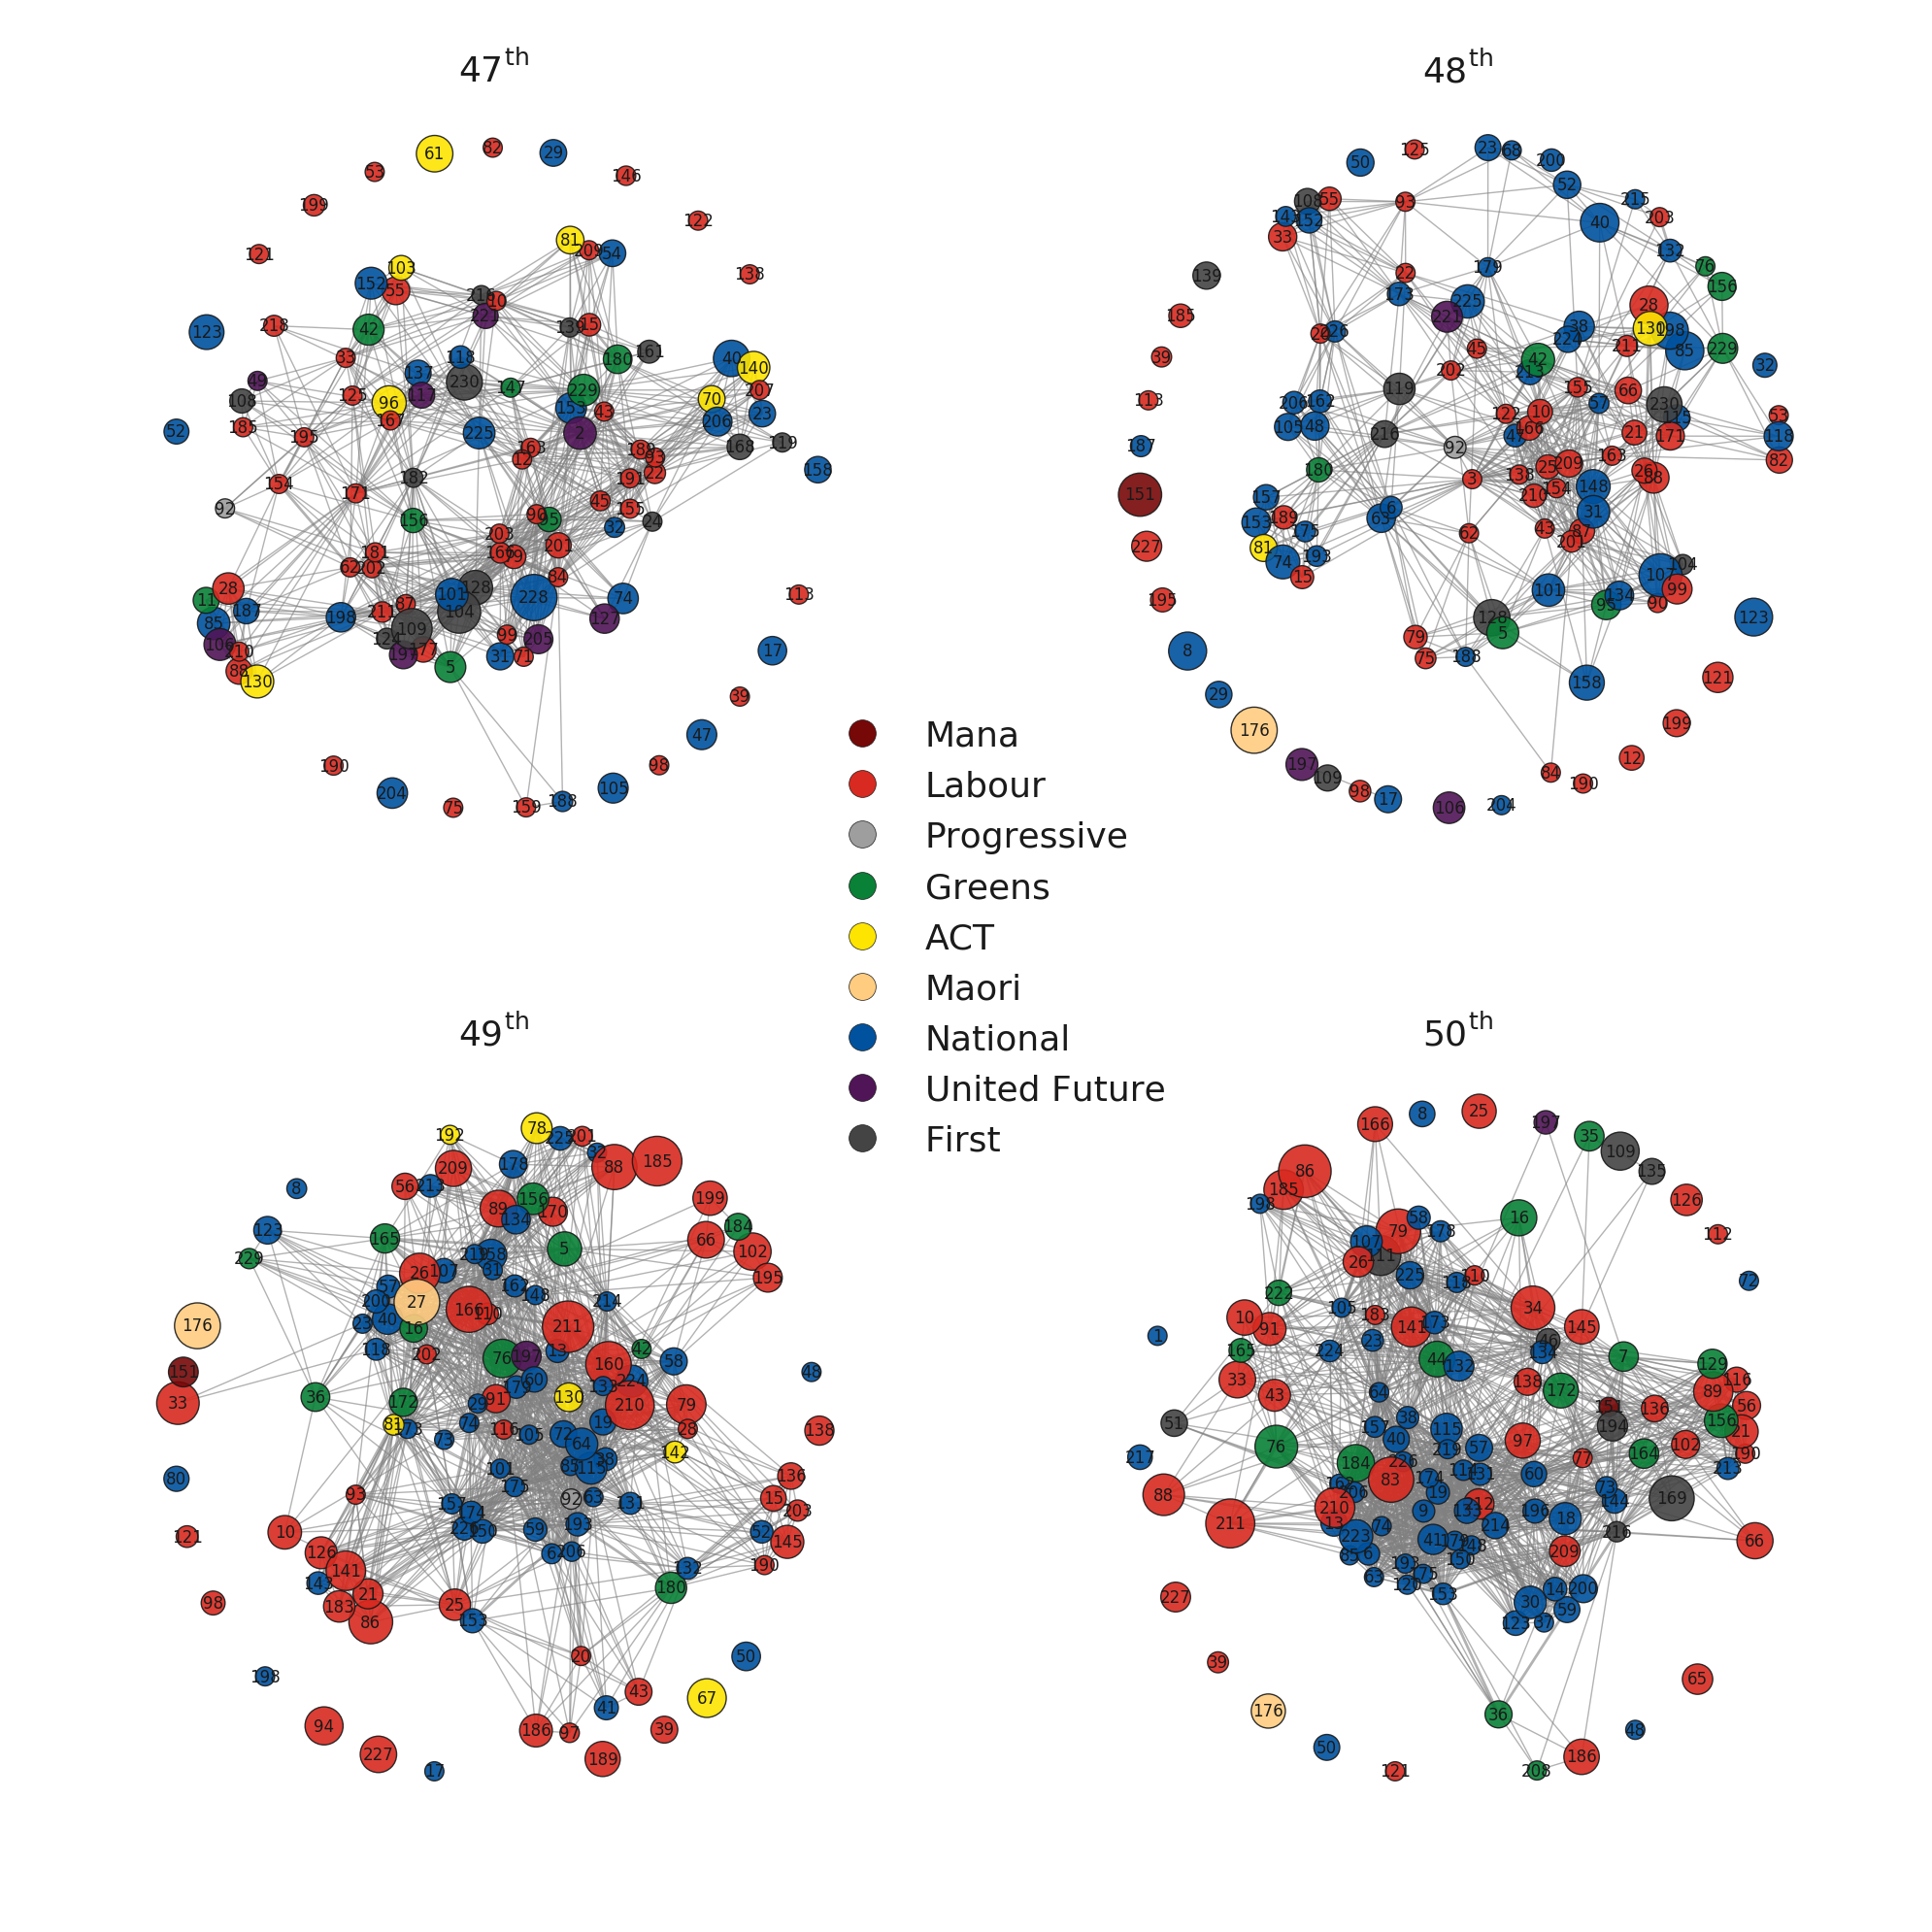

In [81]:
f = plt.figure(1,figsize=(20,20), dpi=500)
#ax = [fig.add_subplot(2,2,i+1) for i in range(4)]
#parl_text = [r'$47th$',r'$48th$',r'$49th$',r'$50th$']

for i in range(4):
    plt.subplot(2,2,i+1)
    if i==0:
        pos=nx.fruchterman_reingold_layout(Gw[i],iterations=100,weight='weight',scale=1.0, k=0.11)
    if i==1:
        pos=nx.fruchterman_reingold_layout(Gw[i],iterations=100,weight='weight',scale=1.0, k=0.10)
    if i==2:
        pos=nx.fruchterman_reingold_layout(Gw[i],iterations=100,weight='weight',scale=1.0, k=0.14)
    if i==3:
        pos=nx.fruchterman_reingold_layout(Gw[i],iterations=100,weight='weight',scale=1.0, k=0.14)
    code,size = make_label_size(Gw[i])
    weights = [(Gw[i][u][v]['weight']) for u,v in Gw[i].edges()]
    
    color_map = {'ACT':'#FDE401', 'National':'#00529F', 'Labour':'#d82a20', 'Greens':'#098137', \
                 'Maori':'#FFCC80', 'Progressive':'#9E9E9E', \
                 'United Future':'#501557', 'Mana':'#770808', 'First':'#444444'}

    nx.draw_networkx_nodes(Gw[i], pos=pos, node_size=size, alpha=0.9, \
                       node_color=[color_map[Gw[i].node[node]['party']] for node in Gw[i]])
    nx.draw_networkx_edges(Gw[i], pos=pos, width=weights, alpha=0.6, edge_color='#808080')
    nx.draw_networkx_labels(Gw[i], pos=pos, labels=code, font_size=12)
    
    plt.text(.55,1.1,parl_text[i], horizontalalignment='right', fontsize=26)#, transform=ax4.transAxes)
    plt.tight_layout()
    plt.axis('off')
    
    if i == 0:
        #plt.legend(loc='upper right', frameon=False)
        markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
        lgnd = plt.legend(markers, color_map.keys(), numpoints=1, loc=(0.85,-0.25), frameon=False, \
                          fontsize=26, ncol=1)
        for i in range(len(color_map)):
            lgnd.legendHandles[i]._legmarker.set_markersize(20)
        #plt.text(1.9,-0.15,r'Labour party in government (2002-2005 and 2005-2008)', horizontalalignment='right', \
                 #fontsize=24)#, transform=ax4.transAxes)
        
    #if i == 3:
        #plt.text(0.42,-0.15,r'National party in government (2008-2011 and 2011-2014)', horizontalalignment='right', \
                 #fontsize=24)#, transform=ax4.transAxes)
    
#Save and show
#plt.savefig("graphs/networks_test.jpg", bbox_inches='tight', format='jpg', dpi=300)
plt.show()

### All networks in same plot - plotting according to communities instead of parties (to be done)

In [ ]:
f = plt.figure(1,figsize=(20,20), dpi=500)
#ax = [fig.add_subplot(2,2,i+1) for i in range(4)]
#parl_text = [r'$47th$',r'$48th$',r'$49th$',r'$50th$']

for i in range(4):
    plt.subplot(2,2,i+1)
    if i==0:
        pos=nx.fruchterman_reingold_layout(Gw[i],iterations=100,weight='weight',scale=1.0, k=0.11)
    if i==1:
        pos=nx.fruchterman_reingold_layout(Gw[i],iterations=100,weight='weight',scale=1.0, k=0.10)
    if i==2:
        pos=nx.fruchterman_reingold_layout(Gw[i],iterations=100,weight='weight',scale=1.0, k=0.14)
    if i==3:
        pos=nx.fruchterman_reingold_layout(Gw[i],iterations=100,weight='weight',scale=1.0, k=0.14)
    code,size = make_label_size(Gw[i])
    weights = [(Gw[i][u][v]['weight']) for u,v in Gw[i].edges()]
    
    color_map = {'ACT':'#FDE401', 'National':'#00529F', 'Labour':'#d82a20', 'Greens':'#098137', \
                 'Maori':'#FFCC80', 'Progressive':'#9E9E9E', \
                 'United Future':'#501557', 'Mana':'#770808', 'First':'#444444'}

    nx.draw_networkx_nodes(Gw[i], pos=pos, node_size=size, alpha=0.9, \
                       node_color=[color_map[Gw[i].node[node]['party']] for node in Gw[i]])
    nx.draw_networkx_edges(Gw[i], pos=pos, width=weights, alpha=0.6, edge_color='#808080')
    nx.draw_networkx_labels(Gw[i], pos=pos, labels=code, font_size=12)
    
    plt.text(.55,1.1,parl_text[i], horizontalalignment='right', fontsize=26)#, transform=ax4.transAxes)
    plt.tight_layout()
    plt.axis('off')
    
    if i == 0:
        #plt.legend(loc='upper right', frameon=False)
        markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
        lgnd = plt.legend(markers, color_map.keys(), numpoints=1, loc=(0.85,-0.25), frameon=False, \
                          fontsize=26, ncol=1)
        for i in range(len(color_map)):
            lgnd.legendHandles[i]._legmarker.set_markersize(20)
        #plt.text(1.9,-0.15,r'Labour party in government (2002-2005 and 2005-2008)', horizontalalignment='right', \
                 #fontsize=24)#, transform=ax4.transAxes)
        
    #if i == 3:
        #plt.text(0.42,-0.15,r'National party in government (2008-2011 and 2011-2014)', horizontalalignment='right', \
                 #fontsize=24)#, transform=ax4.transAxes)
    
#Save and show
plt.savefig("graphs/networks.png", bbox_inches='tight', format='png', dpi=500)
plt.show()

In [ ]:
print mps[mp_ids.index('132')], mp_party[mp_ids.index('132')], words[mp_ids.index('132')]
print mps[mp_ids.index('28')], mp_party[mp_ids.index('28')], words[mp_ids.index('28')]
print mps[mp_ids.index('204')], mp_party[mp_ids.index('204')], words[mp_ids.index('204')]
print mps[mp_ids.index('185')], mp_party[mp_ids.index('185')], words[mp_ids.index('185')]

## Codes, MPs and topics per MP

In [82]:
mp_dict = {}

for i in range(len(B)):
    top_nodes = set(node for node,d in B[i].nodes(data=True) if d['bipartite']==0) #dlist
    bottom_nodes = set(B[i]) - top_nodes #klist
    for node in bottom_nodes:
        if node in mp_dict.keys():
            mp_dict[node]['topics'].append(B[i][node])
            mp_dict[node]['words'].append(B[i].node[node]['words'])
        else:
            mp_dict[node] = {'code':B[i].node[node]['code'], 'full-name':B[i].node[node]['name'], \
                             'topics':[B[i][node]], 'words':[B[i].node[node]['words']], \
                             'presence':B[i].node[node]['presence'], 'party':B[i].node[node]['party']}

print mp_dict['wilkinson-kate']
test = []
for e in mp_dict['wilkinson-kate']['topics']:
    test.extend(e.keys())
print test
print list(set(test))

{'code': '148', 'presence': 3, 'topics': [{'Employment': {}, 'Law and order': {}, 'Legislation': {}}, {'Employment': {}, 'Legislation': {}}, {'Canterbury': {}, 'Economy': {}}], 'full-name': 'Kate Wilkinson', 'words': [125757, 34629, 22763], 'party': 'National'}
['Employment', 'Law and order', 'Legislation', 'Employment', 'Legislation', 'Canterbury', 'Economy']
['Legislation', 'Law and order', 'Employment', 'Canterbury', 'Economy']


In [83]:
u_code = []
u_full_name = []
u_presence = []
u_topics = []
u_words = []
u_party = []

for k, value in mp_dict.iteritems():
    u_code.append(mp_dict[k]['code'])
    u_full_name.append(mp_dict[k]['full-name'])
    u_presence.append(mp_dict[k]['presence'])
    int_topics = []
    for d in mp_dict[k]['topics']:
        int_topics.extend(d.keys())
    u_topics.append(list(set(int_topics)))
    u_words.append(sum(mp_dict[k]['words']))
    u_party.append(mp_dict[k]['party'])
    
print len(u_code), len(set(u_code)), u_code[0]
print len(u_party), len(set(u_party)), u_party[0]
print len(u_full_name), len(set(u_full_name)), u_full_name[0]
print len(u_presence), len(set(u_presence)), u_presence[0]
print len(u_topics), u_topics[0]
print len(u_words), len(set(u_words)), u_words[0]

225 225 148
225 9 National
225 225 Kate Wilkinson
225 4 3
225 ['Legislation', 'Law and order', 'Employment', 'Canterbury', 'Economy']
225 225 183149


In [84]:
with open('mpinfo.csv','wr') as csvfile:
    write = csv.writer(csvfile)#, delimiter=' ',
                            #quotechar='|', quoting=csv.QUOTE_MINIMAL) #first arg obrigatory, others optional.
    write.writerows(izip(u_code, u_full_name, u_party, u_presence, u_topics, u_words))

## Words per speech histogram

In [ ]:
members = []
for member in os.listdir('raw-speech-data'):
    members.append(member)
print len(members)  
    
members = []
for member in os.listdir('speech-data'):
    members.append(member)
print len(members)  

members = []
for member in os.listdir('raw-speech'):
    members.append(member)
print len(members)  

In [ ]:
words_per_mp = {}
for mp in mp_unique:
    words_per_mp[mp] = []
    for speech in os.listdir('raw-speech/'+mp):
        #print speech
        out1 = subprocess.Popen(['wc', '-w', 'speech-data/'+mp+'/'+speech], \
                                stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
        out2 = out1.communicate()[0]
        num_words = int(out2.partition(b' ')[0])
        words_per_mp[mp].append(num_words)

In [ ]:
speeches_size = [item for sublist in words_per_mp.values() for item in sublist]

In [ ]:
print len(speeches_size)
print len([size for size in speeches_size if size>150])
print max(speeches_size)

In [ ]:
print len(speeches_size)
print len([size for size in speeches_size if size>150])
print len([size for size in speeches_size if size>2250])
print max(speeches_size)

In [ ]:
#Bottom nodes
import seaborn as sns
sns.set(color_codes=True)

sns.set_style('white')

fig = plt.figure(figsize=(12,6), dpi=500)
ax = fig.add_subplot(1,1,1)

# all speeches
ax.hist(speeches_size, bins=range(min(speeches_size), 2250, 25))
#sns.distplot(speeches_size, bins=bins, kde=False, rug=True, ax=ax)


for i in range(6):
    ax.patches[i].set_edgecolor('k')
    ax.patches[i].set_facecolor('w')


#ax.annotate('', xy=(151, 2000), xycoords='data', xytext=(500, 2500), textcoords='data', \
            #arrowprops=dict(arrowstyle="<-", connectionstyle="angle3"))
#ax.text(0.15, 0.77, 'Threshold of 150 words\nlong speeches', \
        #ha='left', va='center', transform=ax.transAxes, fontsize=20)


#set limits
ax.set_yticks(np.linspace(0,4000,5,endpoint=True))
ax.axvline(x=151, color='gray', linestyle='--', linewidth=1.5)

ax.set_ylim([0,3500])
ax.set_xlim([0,2250])

#Set axis label
ax.set_xlabel('Speech size (number of words)', fontsize=30)
ax.set_ylabel('Frequency', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=22)

#Set legend
plt.legend(loc='upper left', frameon=False, fontsize=16)


plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

#plt.savefig("graphs/speechsizedistribution.eps", format='eps', dpi=500)

plt.show()
sns.reset_orig()

## Testing area